In [2]:
# Importing the libraries

%matplotlib inline
import numpy as np
import pandas as pd
import yfinance as yf
#from nsepy import get_history
from datetime import date
from datetime import timedelta
from tabulate import tabulate
# Technical Analysis Library
import talib as ta
from talib import MA_Type

# Plotting
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
plt.style.use('seaborn-darkgrid')

# Import and filter warnings
import warnings
warnings.filterwarnings("ignore")

In [7]:
# Function to calculate all technical data

def technical(data):
    # data: Dataframe containing stock's Open, High, Low, Close price and daily volume
    
    # Bolinger Bands for Volume
    data['up_bb'], data['mid_bb'], data['low_bb'] = ta.BBANDS(data['Volume'], matype=MA_Type.T3)
    
    # To check for volume-spike if volume is greater than upper BBand
    data["vol_spike"] = np.where(data["Volume"]>data["up_bb"],True,False)
    
    # Bolinger Bands for Closing Price
    data['up_bb_c'], data['mid_bb_c'], data['low_bb_c'] = ta.BBANDS(data['Close'], matype=MA_Type.T3)
    
    # To calculate BBANDs Signal for Long and Short positions
    data['B_signal'] = np.where((data["vol_spike"]==True) & (data["Low"]<= data["low_bb_c"])  
                              ,-1,(np.where((data["vol_spike"]==True) & (data["High"]>= data["up_bb_c"]),1,0)))
 
    
    # To calculate William %R
    data["WILLR"] = ta.WILLR(data['High'], data['Low'], data['Close'], timeperiod=14)
    
    # To calculate William %R Signal for Long and Short positions
    data["W_signal"] = np.where((data["vol_spike"]==True) & (data["WILLR"]>-80)  
                              ,-1,(np.where((data["vol_spike"]==True) & (data["WILLR"]<-20),1,0)))
    
    # To calculate RSI indicator
    data['RSI'] = ta.RSI(data['Close'])
    
    # To calculate RSI indicator signal for Long and Short positions
    data['R_signal'] = np.where((data["vol_spike"]==True) & (data["RSI"]<=80)  
                              ,1,(np.where((data["vol_spike"]==True) & (data["RSI"]>80),-1,0)))
 
    
    # To calculate Stochastic indicator
    data['STOCHF'], data['STOCHS'] = ta.STOCH(np.array(data['High']), np.array(data['Low']),
                                     np.array(data['Close']), fastk_period=14, slowk_period=5, slowk_matype=0,
                                     slowd_period=5, slowd_matype=0)
    
    # To calculate Stochastic signal for Long and Short positions
    data['S_signal'] = np.where((data["vol_spike"]==True) & (data["STOCHF"]>data['STOCHS']) & (data['STOCHF']<80)  
                              ,1,(np.where((data["vol_spike"]==True) & (data["STOCHF"]<data['STOCHS']) & 
                                           (data['STOCHF']<80),-1,0)))
 
    data.dropna(inplace=True)
    return data


In [8]:
# Function to Show the last 100 Entry points for illustration purposes

def entry_display(data,signal):
    # data:Dataframe containing stock's Open, High, Low, Close price and daily volume
    # signal option: "B_signal", "W_signal", "M_signal", "S_signal"
    
    data_plot = data[-100:]
    values = data_plot['Close'].shape[0]

    # Define the plot figure
    plt.figure(figsize=(15, 7))

    # Set the title and axis labels
    plt.title('Signals', fontsize=14)
    plt.xlabel('Days', fontsize=12)
    plt.ylabel('Price', fontsize=12)

    # Plot close price
    plt.plot(range(values), data_plot['Close'])

    # Plot long entry points
    long= np.where((data_plot[signal] == 1), data_plot['Close'], np.nan)

    plt.plot(range(values), long, '^',
             ms=10, label='Long Signal', color='green')

    short =np.where((data_plot[signal] == -1), data_plot['Close'], np.nan)

    plt.plot(range(values), short, '^',
             ms=10, label='Short Signal', color='red')

    plt.legend()

    plt.show()

In [9]:
# Function to exit from Long position

def long_exit(data, exit_date, entry_date, entry_price):
    # Calculate PnL
    pnl = round(np.log(data.loc[exit_date, 'Close']/entry_price), 4)*100
    return pd.DataFrame([('Long',entry_date, entry_price, exit_date, data.loc[exit_date, 'Close'], pnl)])

# Function to exit from Short position

def short_exit(data, exit_date, entry_date, entry_price):
    # Calculate PnL
    pnl = round(np.log(entry_price / data.loc[exit_date, 'Close']), 4)*100
    return pd.DataFrame([('Short',entry_date, entry_price, exit_date, data.loc[exit_date, 'Close'], pnl)])

# Function to Record Entry & Exit

def trade_book(data,signal):
    # data:Dataframe containing stock's Open, High, Low, Close price and daily volume
    # signal option: "B_signal", "W_signal", "M_signal", "S_signal"
    
    # Define the current position and other variables
    current_position = 0
    entry_date = np.nan
    entry_price = np.nan

    trades = pd.DataFrame(columns=range(6))
    i=-1
    # Loop to check the entry and exit logic on each data point
    for date in data.index:
        i=i+1
                    
        # ---------------------------------------------------------------------------------
        # Close open position based on stop loss and profit target
        if current_position == 1:
            # Check for stop loss and profit target
            if ((data.loc[date, 'Low'] < sl)or(data.loc[date,'High']>profit)):
                
                trade_details = long_exit(data, date, entry_time, entry_price)
                trades = trades.append(trade_details, ignore_index=True)
                current_position = 0
                
        elif current_position == -1:
            if ((data.loc[date, 'High'] > sl)or(data.loc[date,'Low']<profit)):
                
                trade_details = short_exit(data, date, entry_time, entry_price)
                trades = trades.append(trade_details, ignore_index=True)
                current_position = 0
            
        # Long entry point
        elif ((current_position == 0) and (data.loc[date,signal]== 1)):
                current_position = 1
                entry_time = date
                entry_price = data.loc[date, 'Close']
                sl = data.loc[date, "Low"]*.97           # Stop Loss 3% lower
                profit = data.loc[date, 'Close'] + 2*(data.loc[date, 'Close']-sl) # Profit Target twice of expected risk
       
        # Short entry point
        elif ((current_position == 0) and (data.loc[date,signal]== -1)):
                current_position = -1
                entry_time = date
                entry_price = data.loc[date, 'Close']
                sl = data.loc[date, "High"]*1.03       # Stop Loss 3% higher
                profit = data.loc[date, 'Close'] - 2*(sl-data.loc[date, 'Close']) # Profit Target twice of expected risk
               
            
    trades.columns = ['Position','Entry Time', 'Entry Price', 'Exit Time', 'Exit Price', 'P&L']

    return trades


In [10]:
# Function to analyse backtest

def backtest(data, trade_book):
    back_test = pd.DataFrame(index=['Strategy Backtest'])

    # Number of trades
    back_test['Number of Trades'] = trade_book.shape[0]

    # Startegy start date
    back_test['Start Date'] = data.index[0]

    # Strategy end date
    back_test['End Date'] = data.index[-1]

    # Duration in months
    back_test['Duration'] = "{} months".format(
        (back_test['End Date'].iloc[0].year -
         back_test['Start Date'].iloc[0].year) * 12 +
        (back_test['End Date'].iloc[0].month -
         back_test['Start Date'].iloc[0].month))

    # Holding time
    trade_book['Holding Days'] = trade_book['Exit Time'] - trade_book['Entry Time']
    back_test['Avg holding Days'] = trade_book['Holding Days'].mean()
    back_test['Med holding Days'] = trade_book['Holding Days'].median()
    back_test['Min holding Days'] = trade_book['Holding Days'].min()
    back_test['Max holding Days'] = trade_book['Holding Days'].max()
    
    display(back_test.astype(object).T)
  

In [11]:
def risk_return(data, trade_book):
    import monthly_returns_heatmap as mrh
    
    risk_return_metrics = pd.DataFrame(index=['Risk & Returns Metric'])
    price_data = data
    # ---------------------Positions---------------------
    # Add the positions to the price_data based on the trade book
    price_data['positions'] = np.nan
    for i in trade_book.index:
        time = trade_book["Entry Time"][i]
        if trade_book["Position"][i]=="Long":
            price_data.loc[time,'positions'] = 1
        elif trade_book["Position"][i]=="Short":
            price_data.loc[time,'positions'] = -1
    price_data.loc[list(trade_book['Exit Time']), 'positions'] = 0
    price_data['positions'].ffill(inplace=True)

    # ---------------------Profit & Loss---------------------
    # Add the PnL column based on the trade book
    price_data['P&L'] = 0
    price_data.loc[list(trade_book['Entry Time']), 'P&L'] = trade_book['P&L'].values

    # ---------------------Strategy returns---------------------
    # Calculate the strategy returns
    
    price_data['strategy_returns'] = price_data['positions'].shift(1) * \
                                     price_data['Close'].pct_change()

    # ---------------------Cumulative returns---------------------
    # Calculate the cumulative returns
    
    price_data['cumulative_returns'] = (1+price_data['strategy_returns']).cumprod()
    risk_return_metrics['Cumulative Return'] = (price_data['cumulative_returns'][-1] - 1)*100

    # ---------------------Annualised return---------------------
    risk_return_metrics['Annualised Return'] = ((price_data['cumulative_returns'][-1]) **
                                           (252/price_data.shape[0]) - 1) * 100

    # ---------------------Profit factor---------------------
    sum_of_profit = price_data[price_data['P&L'] > 0]['P&L'].sum()
    sum_of_loss = -price_data[price_data['P&L'] < 0]['P&L'].sum()
    risk_return_metrics['Profit Factor'] = sum_of_profit / sum_of_loss

    # ---------------------Win rate %---------------------
    count_of_profit = price_data[price_data['P&L'] > 0]['P&L'].count()
    count_of_loss = price_data[price_data['P&L'] < 0]['P&L'].count()
    risk_return_metrics['Win Rate'] = (count_of_profit /(count_of_profit+count_of_loss)) * 100

    # -------------Heatmap of month vs year returns--------------
    fig = plt.figure(figsize=(10, 7))
    mrh.plot(price_data['strategy_returns'])
    plt.tight_layout()
    plt.show()

    # ---------------------Return Curve---------------------
    # Plot cumulative strategy returns
    price_data['cumulative_returns'] = (price_data['cumulative_returns']-1)*100
    price_data['cumulative_returns'].plot(figsize=(10, 7), color='green')
    # Restore data
    price_data['cumulative_returns'] = ((price_data['cumulative_returns']/100)+1)
    plt.title('Cumulative Returns Curve', fontsize=14)
    plt.ylabel('Cumulative returns(%)')
    plt.tight_layout()
    plt.show()
    
    # ---------------------Annualised volatility---------------------
    risk_return_metrics['Annualised Volatility'] = "{0:.2f}%".format(
        price_data['strategy_returns'].std()*np.sqrt(252) * 100)
    
    risk_return_metrics['Sharpe ratio'] = round(price_data['strategy_returns'].mean()/
                   price_data['strategy_returns'].std() * np.sqrt(252), 2)


    # ---------------------Rolling estimation of volatility---------------------
    window_size = 21
    price_data['rolling_volatility'] = price_data['strategy_returns'].rolling(
        window_size).std() * np.sqrt(252) * 100
    price_data['rolling_volatility'].plot(figsize=(10,7), color='green')
    plt.title('21 Days Rolling Volatility', fontsize=14)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Volatility', fontsize=12)
    plt.tight_layout()
    plt.show()

    # ---------------------Max drawdown---------------------
    # Calculate the running maximum
    running_max = np.maximum.accumulate(price_data['cumulative_returns'].dropna())
    # Ensure the value never drops below 1
    running_max[running_max < 1] = 1
    # Calculate the percentage drawdown
    drawdown = ((price_data['cumulative_returns'])/running_max - 1) * 100

    # Calculate the maximum drawdown
    risk_return_metrics['Maximum Drawdown'] = "{0:.2f}%".format(drawdown.min())

    # ---------------------DD plot---------------------
    fig = plt.figure(figsize=(10, 7))

    # Plot max drawdown
    plt.plot(drawdown, color='red')
    # Fill in-between the drawdown
    plt.fill_between(drawdown.index, drawdown.values, color='red')
    plt.title('Strategy Drawdown', fontsize=14)
    plt.ylabel('Drawdown(%)', fontsize=12)
    plt.xlabel('Year', fontsize=12)

    plt.tight_layout()
    plt.show()

    display(risk_return_metrics.astype(object).T)
   

In [12]:
# Function to analyse the strategy
def strategy_analysis(data, signal):
    entry_display(data,signal)
    trd = trade_book(data,signal)
    backtest(data, trd)
    risk_return(data, trd)
        

In [8]:
# Lets select Top Four Constituents by Weightage of NIFTY50 Index of INDIA for backtesting our strategies

print("\nTop Four Constituents by Weightage of NIFTY50 Index of INDIA:\n")
w_table = [['Company’s Name','Sector','Weight%'],
           ['Reliance Industries Ltd.','Refineries',12.94],
           ['HDFC Bank Ltd.','Finance - Banks - Private Sector',08.55],
           ['Infosys Ltd.','IT Consulting & Software',07.73],
           ['ICICI Bank Ltd.','Finance - Banks - Private Sector',07.11]]

print(tabulate(w_table,headers='firstrow',tablefmt='fancy_grid',showindex=range(1,5)))


Top Four Constituents by Weightage of NIFTY50 Index of INDIA:

╒════╤══════════════════════════╤══════════════════════════════════╤═══════════╕
│    │ Company’s Name           │ Sector                           │   Weight% │
╞════╪══════════════════════════╪══════════════════════════════════╪═══════════╡
│  1 │ Reliance Industries Ltd. │ Refineries                       │     12.94 │
├────┼──────────────────────────┼──────────────────────────────────┼───────────┤
│  2 │ HDFC Bank Ltd.           │ Finance - Banks - Private Sector │      8.55 │
├────┼──────────────────────────┼──────────────────────────────────┼───────────┤
│  3 │ Infosys Ltd.             │ IT Consulting & Software         │      7.73 │
├────┼──────────────────────────┼──────────────────────────────────┼───────────┤
│  4 │ ICICI Bank Ltd.          │ Finance - Banks - Private Sector │      7.11 │
╘════╧══════════════════════════╧══════════════════════════════════╧═══════════╛


In [9]:
# To download & Prepare the data

# For Reliance Industries Ltd
data_reliance = yf.download("RELIANCE.NS", start="2016-01-01",end="2020-12-31",
                 auto_adjust = True)
data_reliance = technical(data_reliance)

# For HDFC Bank
data_hdfcbank = yf.download("HDFCBANK.NS", start="2016-01-01",end="2020-12-31",
                 auto_adjust = True)
data_hdfcbank = technical(data_hdfcbank)

# For Infosys Ltd
data_infy = yf.download("INFY.NS", start="2016-01-01",end="2020-12-31",
                 auto_adjust = True)
data_infy = technical(data_infy)

# For HDFC Bank
data_icicibank = yf.download("ICICIBANK.NS", start="2016-01-01",end="2020-12-31",
                 auto_adjust = True)
data_icicibank = technical(data_icicibank)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [10]:
print("\n-------------------------------------------------------------------")
print("Strategies Analysis for Reliance Industries")
print("-------------------------------------------------------------------\n")


-------------------------------------------------------------------
Strategies Analysis for Reliance Industries
-------------------------------------------------------------------




BolingerBands strategy with Power Spike for Reliance Industries
---------------------------------------------------------------------



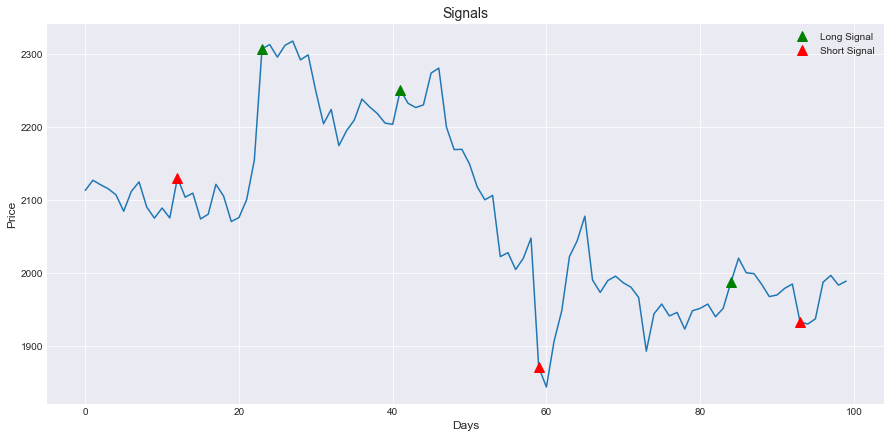

Strategy Backtest
Number of Trades                          34
Start Date               2016-02-05 00:00:00
End Date                 2020-12-30 00:00:00
Duration                           58 months
Avg holding Days  22 days 14:07:03.529411764
Med holding Days            14 days 12:00:00
Min holding Days             4 days 00:00:00
Max holding Days            70 days 00:00:00

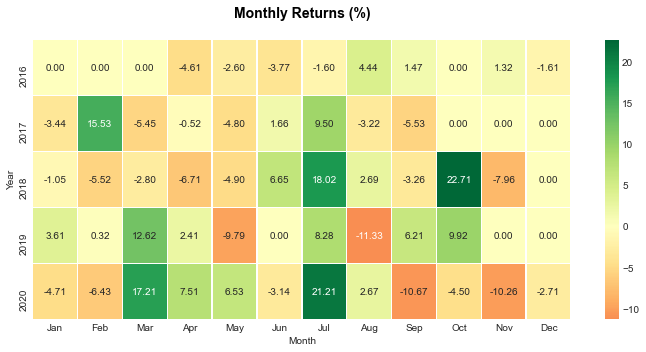

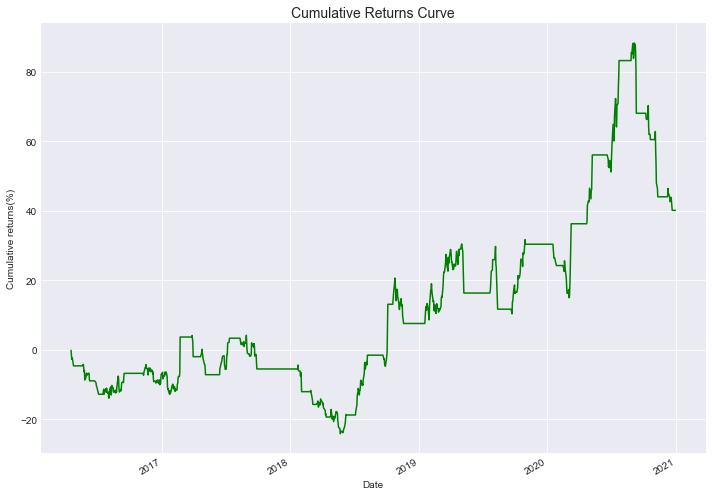

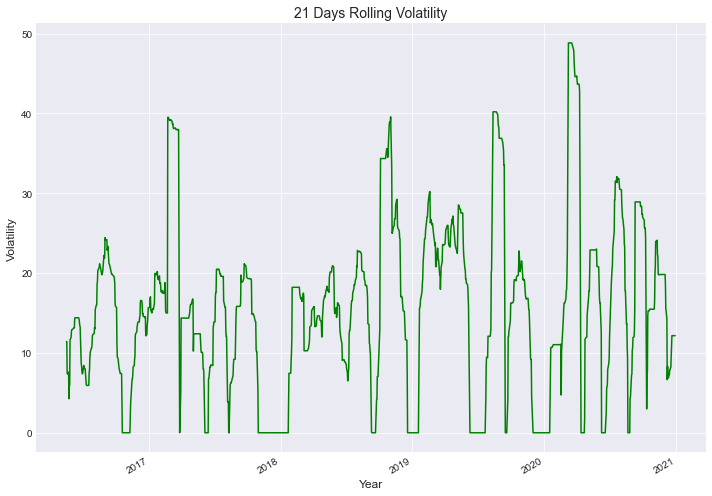

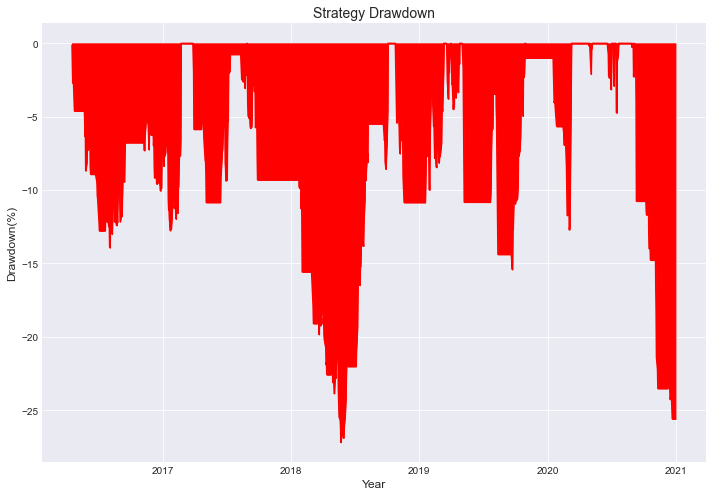

Risk & Returns Metric
Cumulative Return                 40.149418
Annualised Return                  7.288954
Profit Factor                      1.355528
Win Rate                          38.235294
Annualised Volatility                18.85%
Sharpe ratio                           0.48
Maximum Drawdown                    -27.19%

In [11]:
# To analyse BolingerBands strategy with Power Spike for Reliance Industries
print("\nBolingerBands strategy with Power Spike for Reliance Industries")
print("---------------------------------------------------------------------\n")
strategy_analysis(data_reliance, "B_signal")


William %R strategy with Power Spike for Reliance Industries
---------------------------------------------------------------------



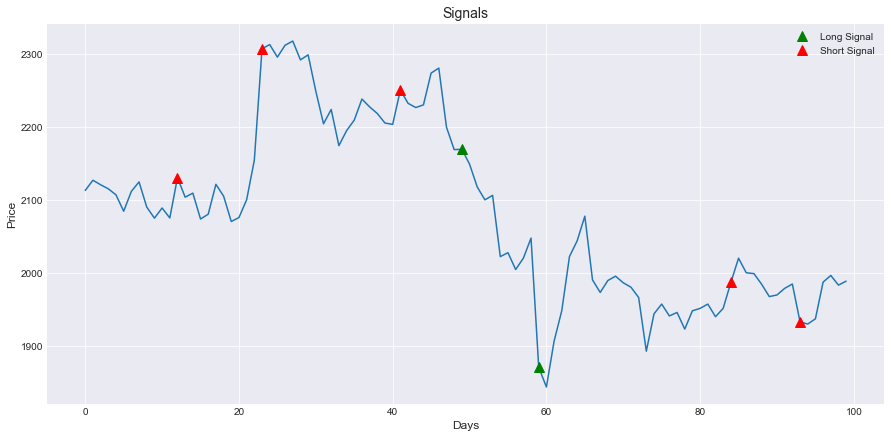

Strategy Backtest
Number of Trades                   45
Start Date        2016-02-05 00:00:00
End Date          2020-12-30 00:00:00
Duration                    58 months
Avg holding Days     16 days 08:32:00
Med holding Days     12 days 00:00:00
Min holding Days      1 days 00:00:00
Max holding Days     49 days 00:00:00

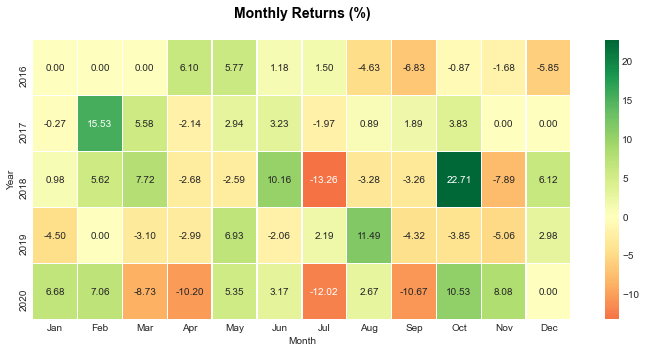

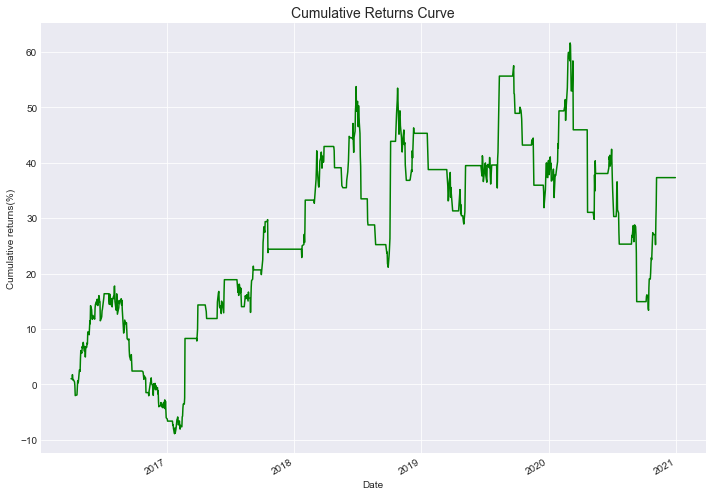

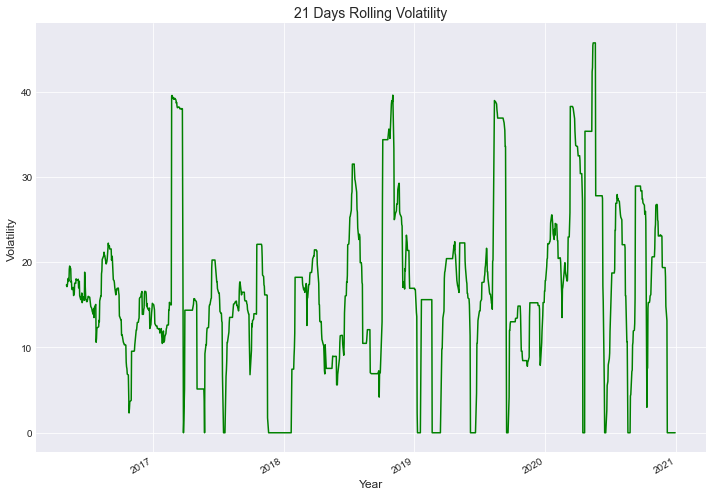

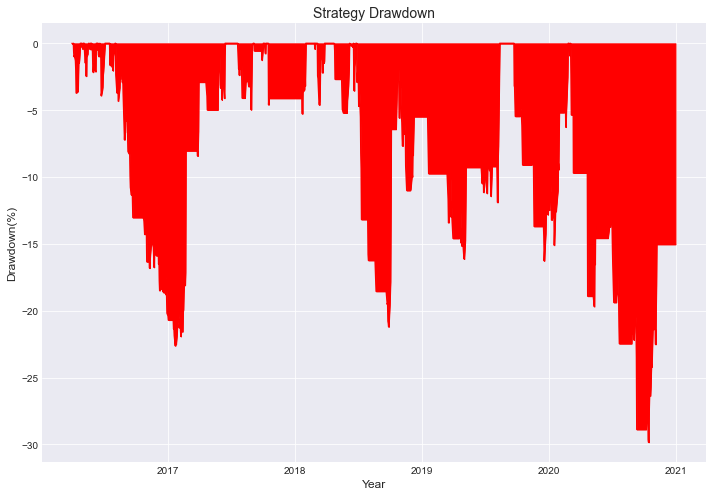

Risk & Returns Metric
Cumulative Return                 37.299347
Annualised Return                  6.830476
Profit Factor                      1.381774
Win Rate                          44.444444
Annualised Volatility                19.05%
Sharpe ratio                           0.45
Maximum Drawdown                    -29.84%

In [12]:
# To analyse William %R strategy with Power Spike for Reliance Industries
print("\nWilliam %R strategy with Power Spike for Reliance Industries")
print("---------------------------------------------------------------------\n")

strategy_analysis(data_reliance, "W_signal")


Stochastic Oscillator strategy with Power Spike for Reliance Industries
---------------------------------------------------------------------



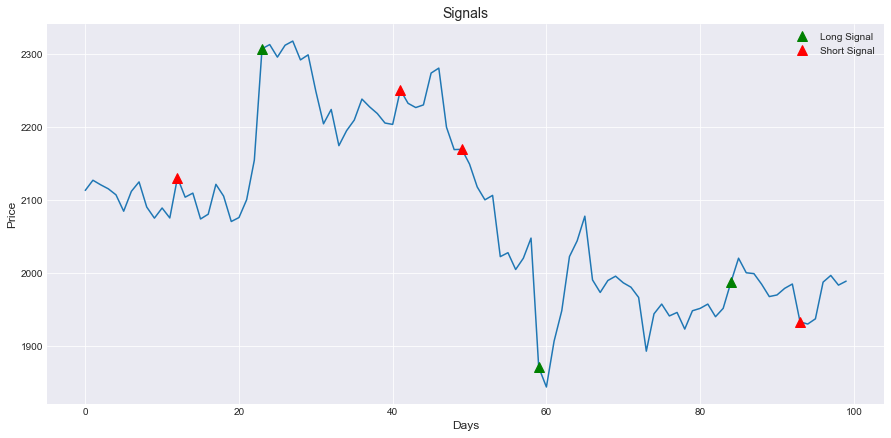

Strategy Backtest
Number of Trades                          35
Start Date               2016-02-05 00:00:00
End Date                 2020-12-30 00:00:00
Duration                           58 months
Avg holding Days  21 days 17:08:34.285714285
Med holding Days            14 days 00:00:00
Min holding Days             3 days 00:00:00
Max holding Days           105 days 00:00:00

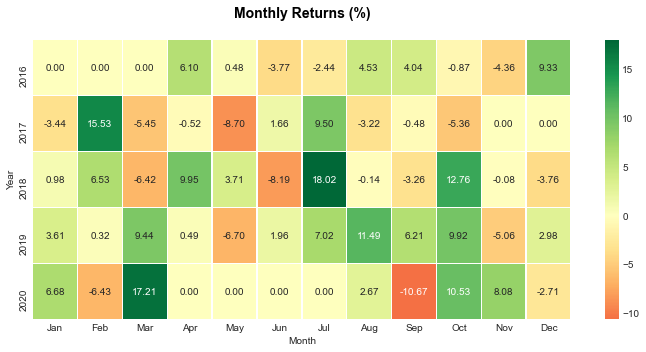

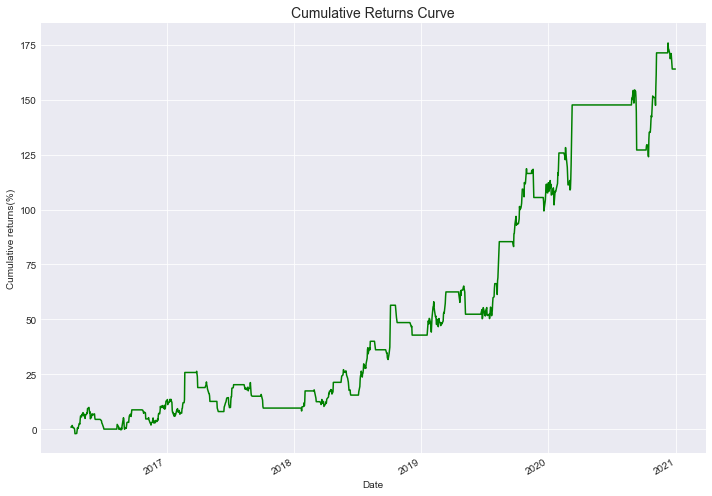

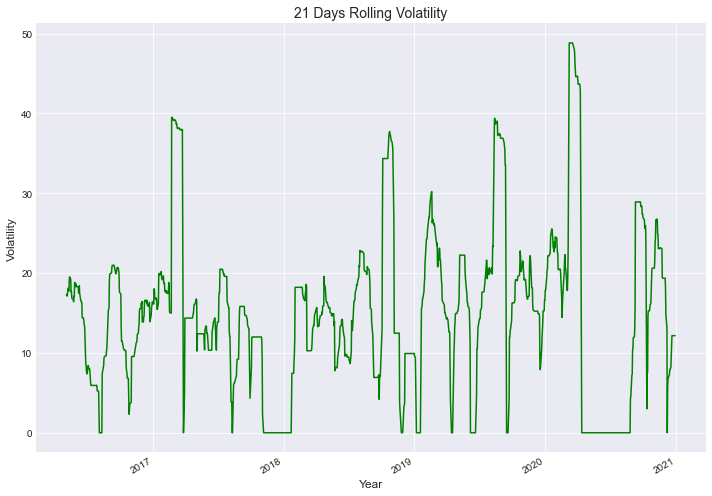

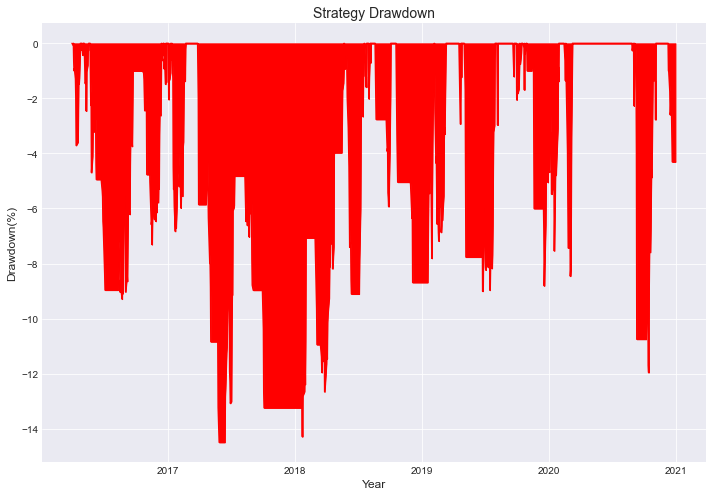

Risk & Returns Metric
Cumulative Return                163.952858
Annualised Return                 22.422593
Profit Factor                      2.209151
Win Rate                          48.571429
Annualised Volatility                18.02%
Sharpe ratio                           1.25
Maximum Drawdown                    -14.50%

In [13]:
# To analyse Stochastic oscillator strategy with Power Spike for Reliance Industries
print("\nStochastic Oscillator strategy with Power Spike for Reliance Industries")
print("---------------------------------------------------------------------\n")

strategy_analysis(data_reliance, "S_signal")


RSI Indicator strategy with Power Spike for Reliance Industries
---------------------------------------------------------------------



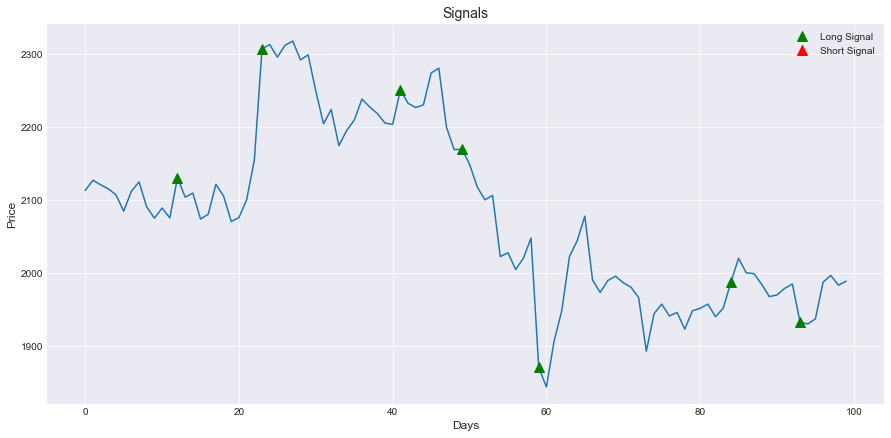

Strategy Backtest
Number of Trades                          35
Start Date               2016-02-05 00:00:00
End Date                 2020-12-30 00:00:00
Duration                           58 months
Avg holding Days  29 days 05:29:08.571428571
Med holding Days            21 days 00:00:00
Min holding Days             3 days 00:00:00
Max holding Days           105 days 00:00:00

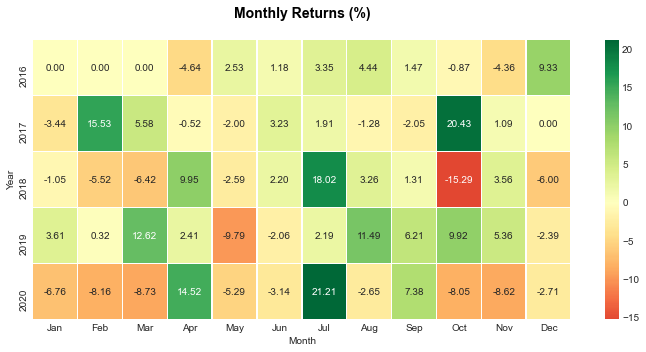

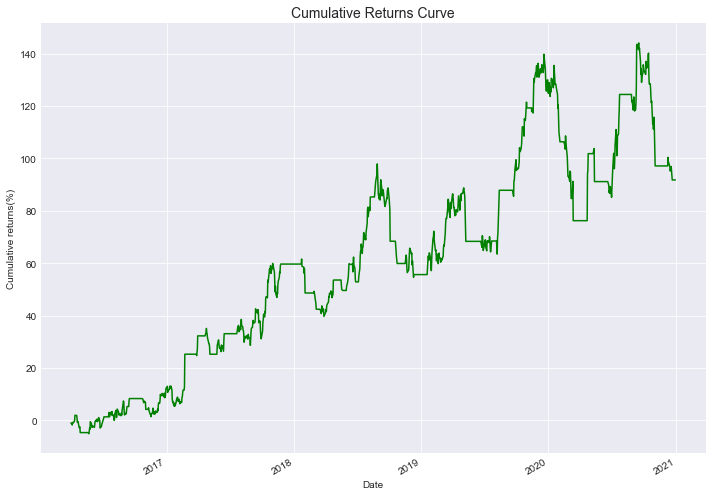

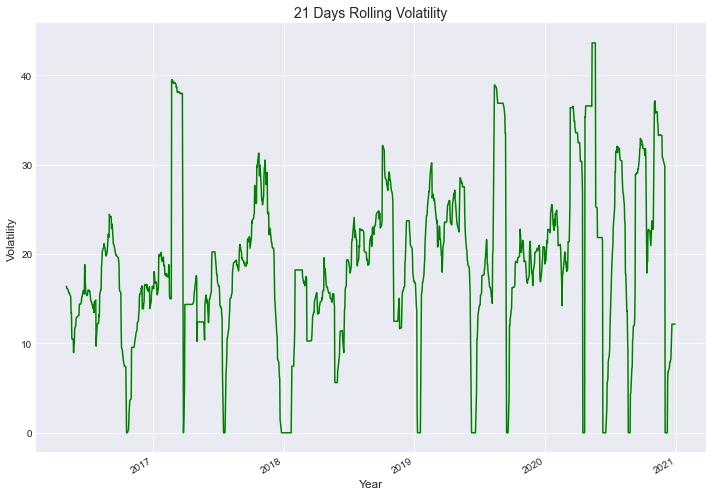

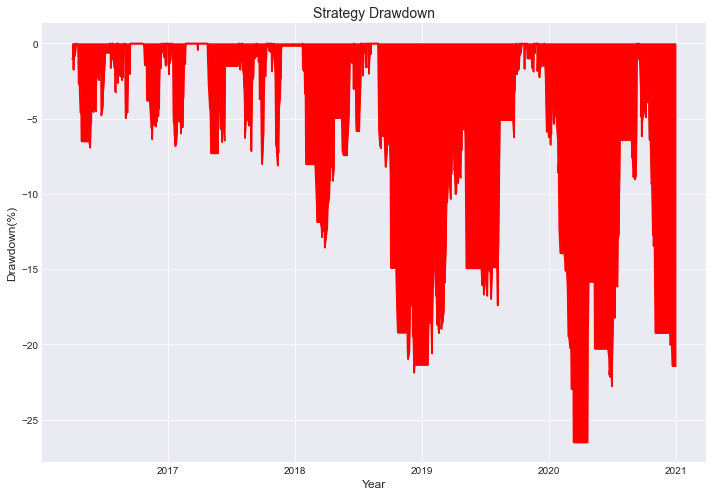

Risk & Returns Metric
Cumulative Return                 91.807693
Annualised Return                 14.540656
Profit Factor                      1.665304
Win Rate                          48.571429
Annualised Volatility                20.98%
Sharpe ratio                           0.77
Maximum Drawdown                    -26.50%

In [14]:
# To analyse RSI indicator strategy with Power Spike for Reliance Industries
print("\nRSI Indicator strategy with Power Spike for Reliance Industries")
print("---------------------------------------------------------------------\n")

strategy_analysis(data_reliance, "R_signal")

In [15]:
print("\n-------------------------------------------------------------------")
print("Strategies Analysis for HDFC BANK")
print("-------------------------------------------------------------------\n")


-------------------------------------------------------------------
Strategies Analysis for HDFC BANK
-------------------------------------------------------------------




BolingerBands strategy with Power Spike for HDFC BANK
---------------------------------------------------------------------



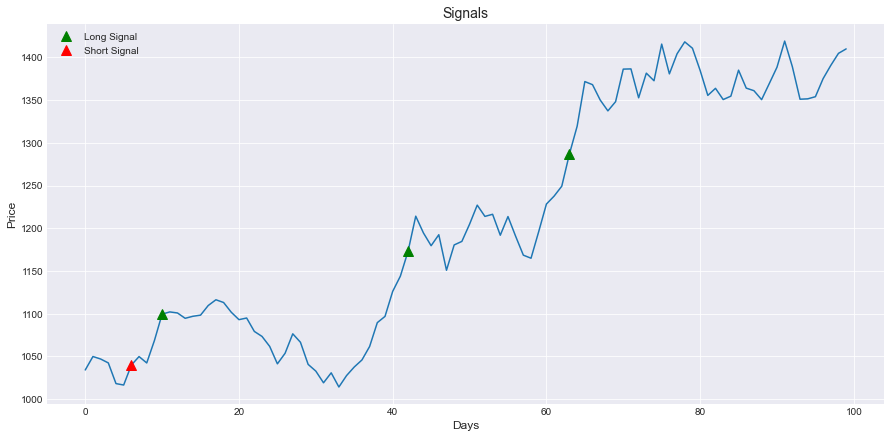

Strategy Backtest
Number of Trades                          23
Start Date               2016-02-05 00:00:00
End Date                 2020-12-30 00:00:00
Duration                           58 months
Avg holding Days  38 days 13:33:54.782608695
Med holding Days            18 days 00:00:00
Min holding Days             1 days 00:00:00
Max holding Days           150 days 00:00:00

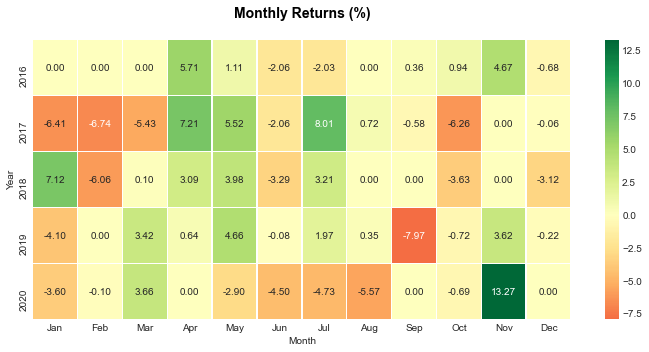

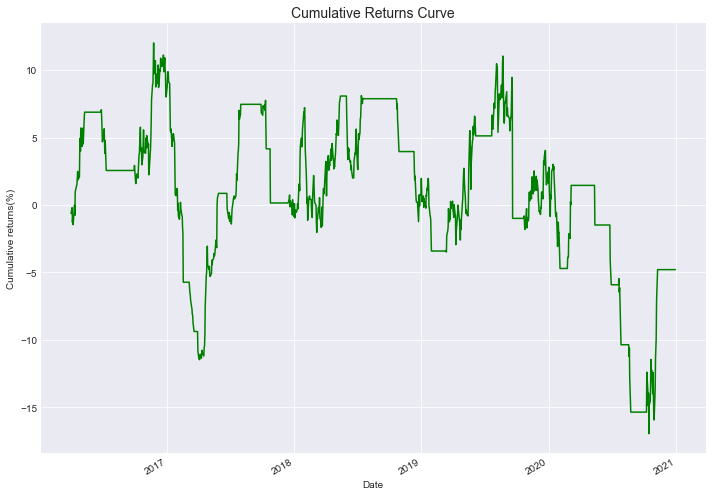

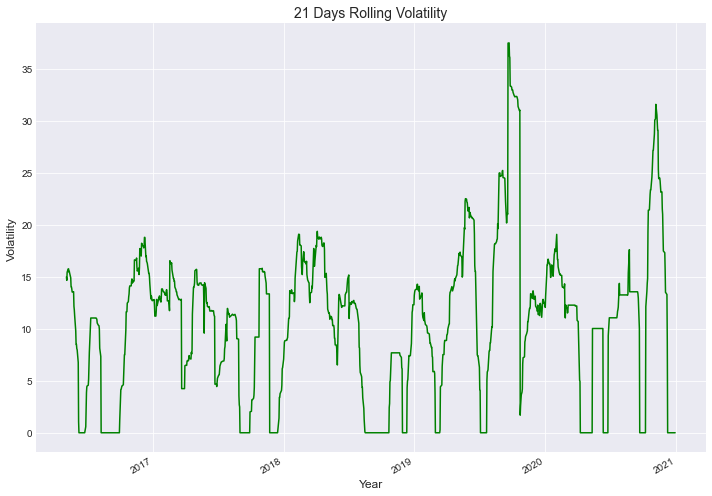

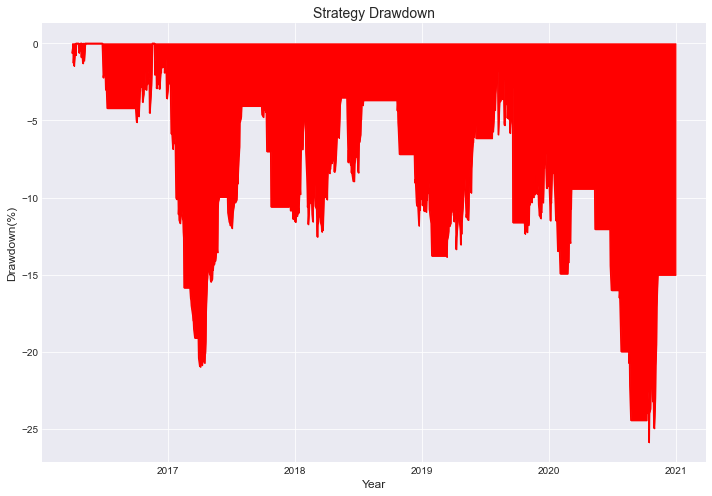

Risk & Returns Metric
Cumulative Return                 -4.789158
Annualised Return                 -1.017718
Profit Factor                       0.97246
Win Rate                          34.782609
Annualised Volatility                12.89%
Sharpe ratio                          -0.02
Maximum Drawdown                    -25.87%

In [16]:
# To analyse BolingerBands strategy with Power Spike for HDFC BANK
print("\nBolingerBands strategy with Power Spike for HDFC BANK")
print("---------------------------------------------------------------------\n")

strategy_analysis(data_hdfcbank, "B_signal")


William %R strategy with Power Spike for HDFC BANK
---------------------------------------------------------------------



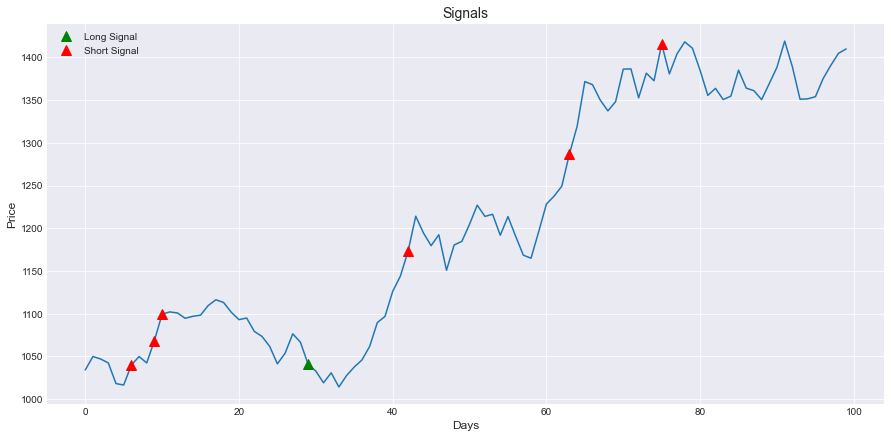

Strategy Backtest
Number of Trades                   30
Start Date        2016-02-05 00:00:00
End Date          2020-12-30 00:00:00
Duration                    58 months
Avg holding Days     30 days 19:12:00
Med holding Days     19 days 00:00:00
Min holding Days      1 days 00:00:00
Max holding Days    111 days 00:00:00

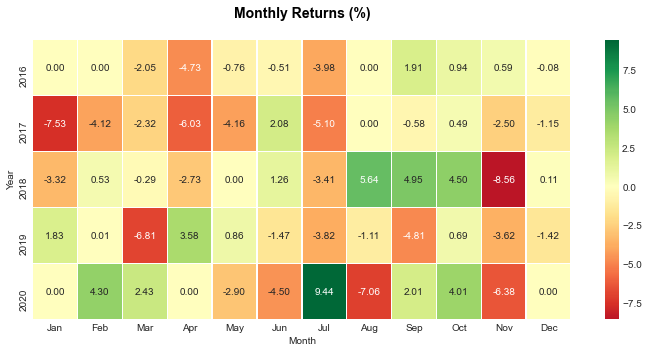

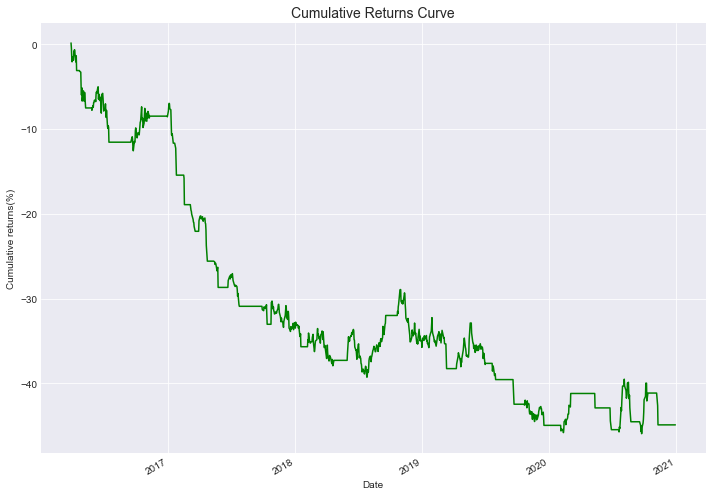

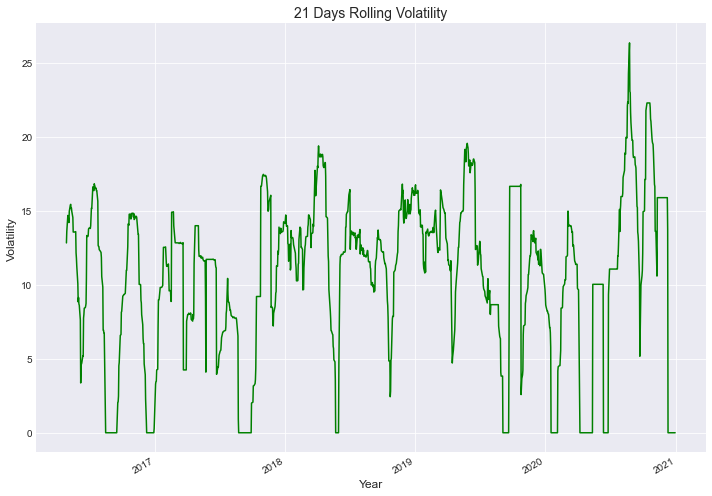

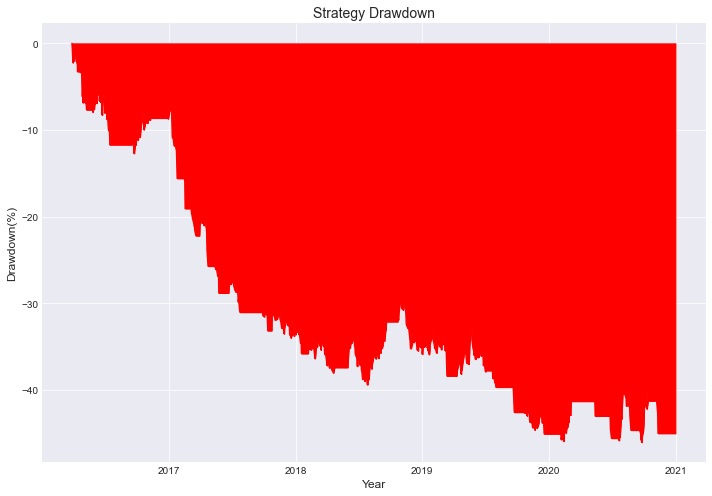

Risk & Returns Metric
Cumulative Return                -44.887868
Annualised Return                -11.678504
Profit Factor                      0.454703
Win Rate                               20.0
Annualised Volatility                11.92%
Sharpe ratio                          -1.01
Maximum Drawdown                    -46.03%

In [17]:
# To analyse William %R strategy with Power Spike for HDFC BANK
print("\nWilliam %R strategy with Power Spike for HDFC BANK")
print("---------------------------------------------------------------------\n")

strategy_analysis(data_hdfcbank, "W_signal")


Stochastic Oscillator strategy with Power Spike for HDFC BANK
---------------------------------------------------------------------



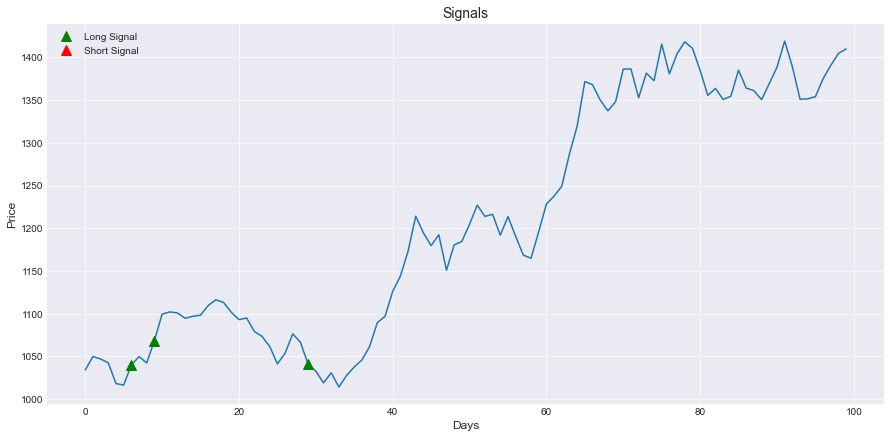

Strategy Backtest
Number of Trades                   24
Start Date        2016-02-05 00:00:00
End Date          2020-12-30 00:00:00
Duration                    58 months
Avg holding Days     40 days 13:00:00
Med holding Days     25 days 00:00:00
Min holding Days      1 days 00:00:00
Max holding Days    178 days 00:00:00

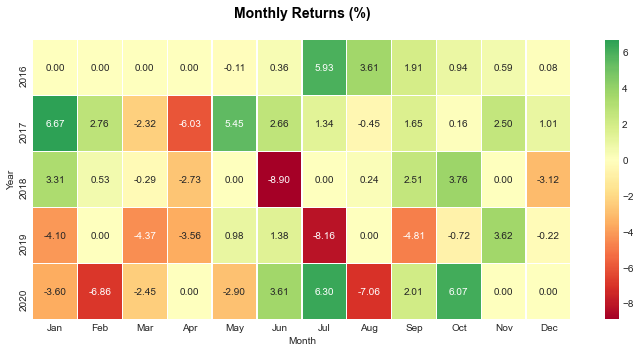

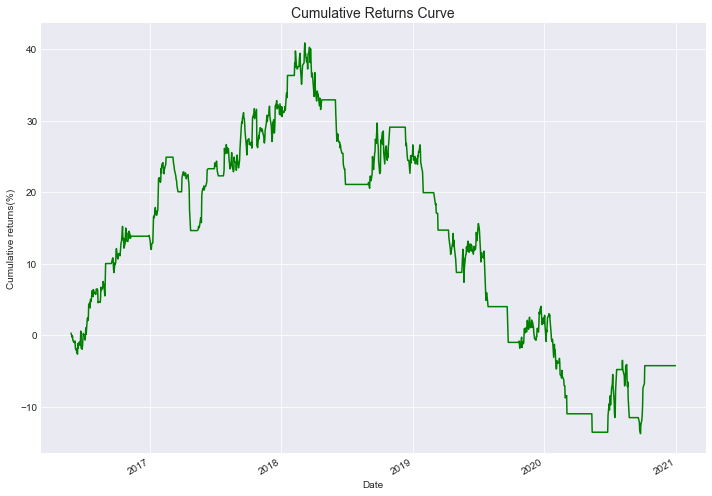

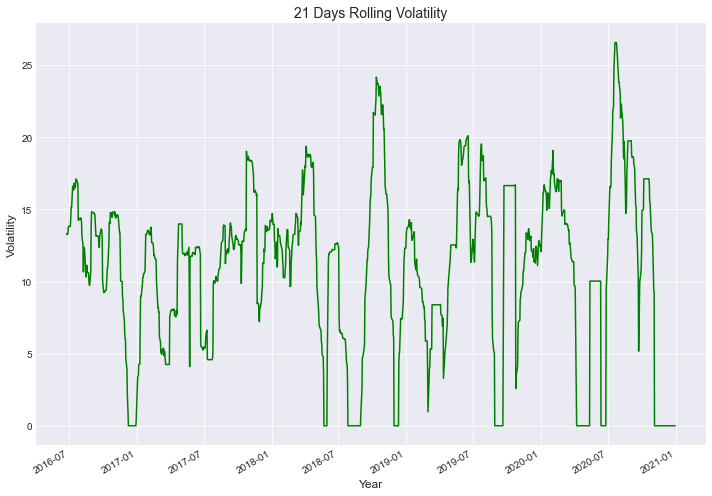

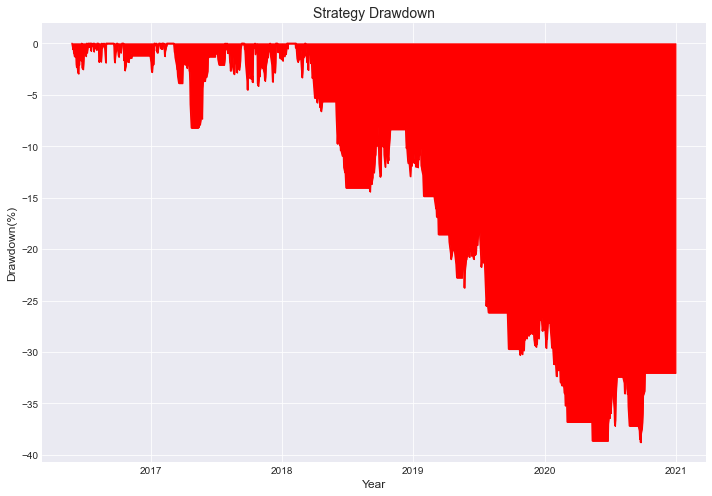

Risk & Returns Metric
Cumulative Return                 -4.262183
Annualised Return                 -0.903775
Profit Factor                      0.972405
Win Rate                          33.333333
Annualised Volatility                12.46%
Sharpe ratio                          -0.02
Maximum Drawdown                    -38.79%

In [18]:
# To analyse Stochastic oscillator strategy with Power Spike for HDFC BANK
print("\nStochastic Oscillator strategy with Power Spike for HDFC BANK")
print("---------------------------------------------------------------------\n")

strategy_analysis(data_hdfcbank, "S_signal")


RSI Indicator strategy with Power Spike for HDFC BANK
---------------------------------------------------------------------



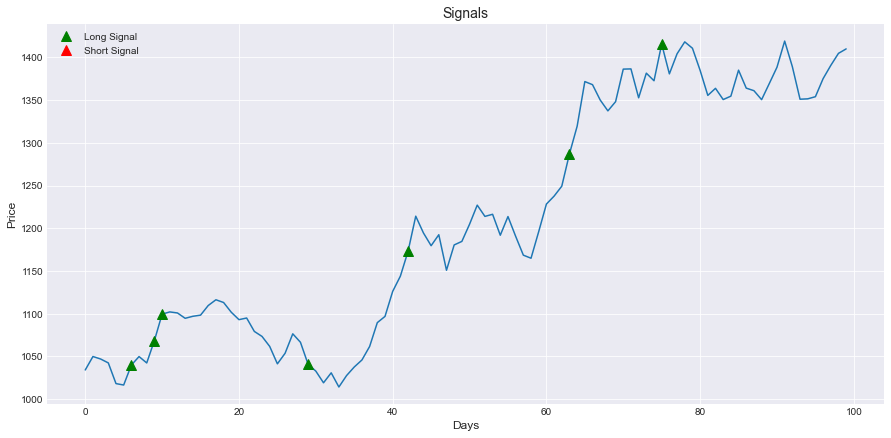

Strategy Backtest
Number of Trades                          23
Start Date               2016-02-05 00:00:00
End Date                 2020-12-30 00:00:00
Duration                           58 months
Avg holding Days  47 days 14:36:31.304347826
Med holding Days            36 days 00:00:00
Min holding Days             6 days 00:00:00
Max holding Days           171 days 00:00:00

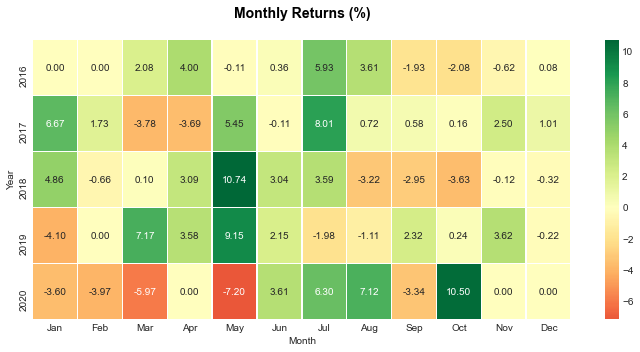

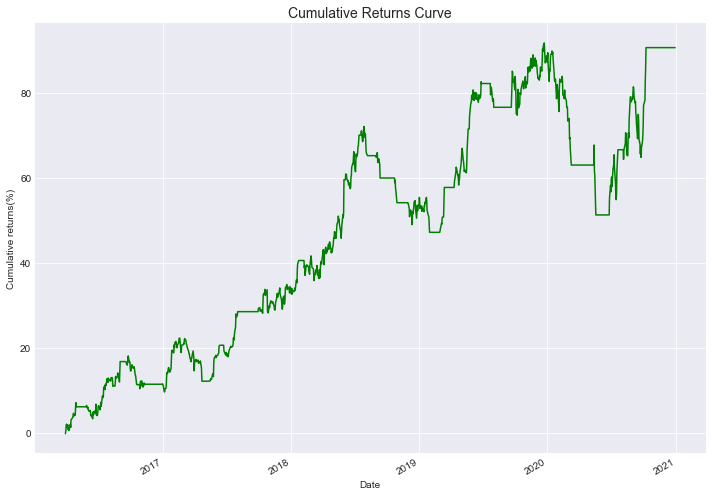

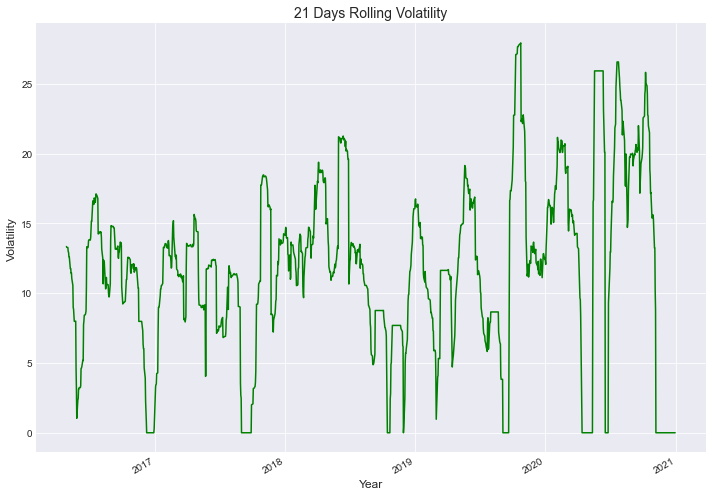

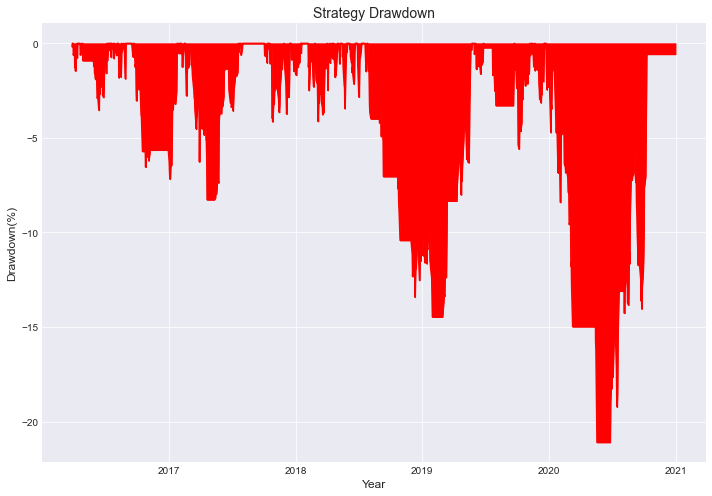

Risk & Returns Metric
Cumulative Return                 90.641593
Annualised Return                  14.39516
Profit Factor                      2.405376
Win Rate                          60.869565
Annualised Volatility                13.36%
Sharpe ratio                            1.1
Maximum Drawdown                    -21.10%

In [19]:
# To analyse RSI indicator strategy with Power Spike for HDFC BANK
print("\nRSI Indicator strategy with Power Spike for HDFC BANK")
print("---------------------------------------------------------------------\n")

trd1=strategy_analysis(data_hdfcbank, "R_signal")

In [20]:
print("\n-------------------------------------------------------------------")
print("Strategies Analysis for INFOSYS")
print("-------------------------------------------------------------------\n")


-------------------------------------------------------------------
Strategies Analysis for INFOSYS
-------------------------------------------------------------------




BolingerBands strategy with Power Spike for INFOSYS
---------------------------------------------------------------------



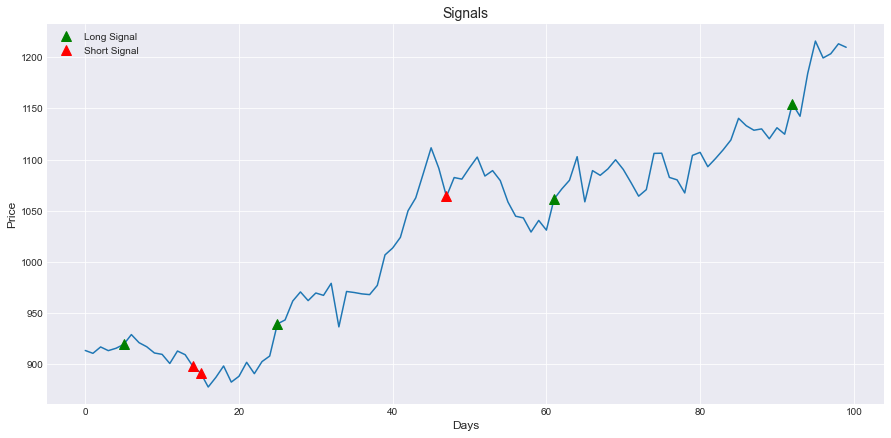

Strategy Backtest
Number of Trades                          29
Start Date               2016-02-05 00:00:00
End Date                 2020-12-30 00:00:00
Duration                           58 months
Avg holding Days  39 days 19:51:43.448275862
Med holding Days            11 days 00:00:00
Min holding Days             1 days 00:00:00
Max holding Days           557 days 00:00:00

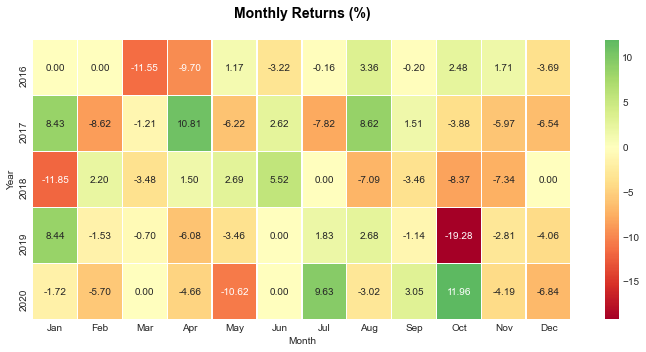

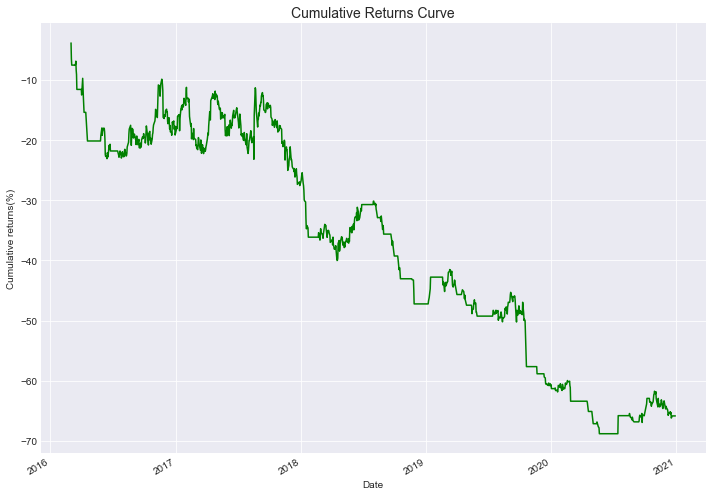

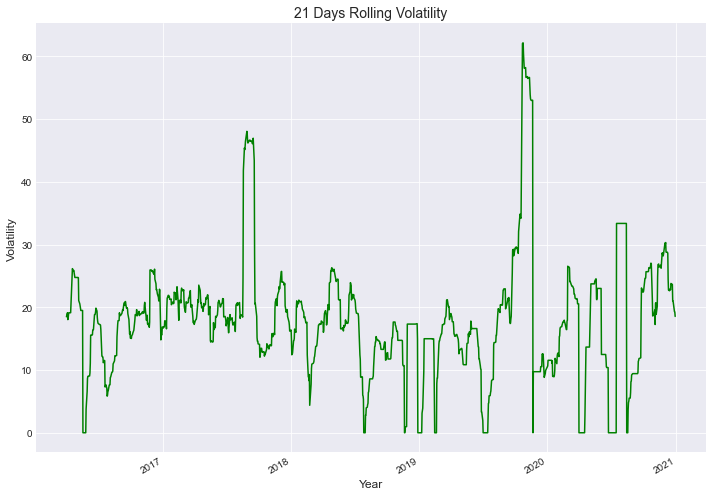

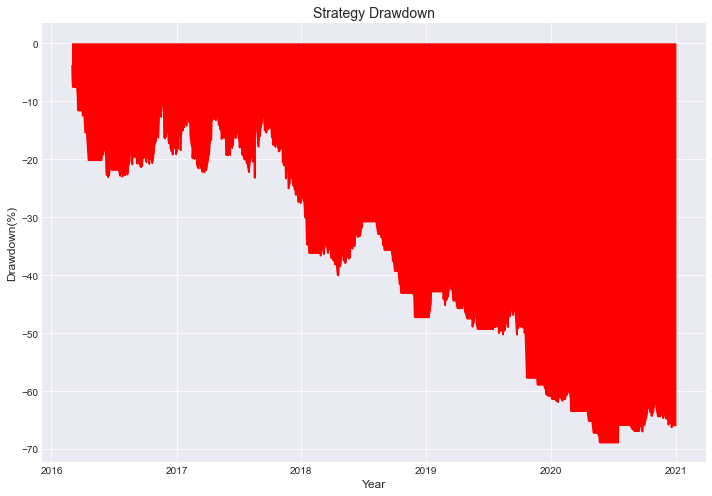

Risk & Returns Metric
Cumulative Return                -65.859757
Annualised Return                -20.068931
Profit Factor                      0.290164
Win Rate                          13.793103
Annualised Volatility                20.24%
Sharpe ratio                          -1.02
Maximum Drawdown                    -68.82%

In [21]:
# To analyse BolingerBands strategy with Power Spike for INFOSYS
print("\nBolingerBands strategy with Power Spike for INFOSYS")
print("---------------------------------------------------------------------\n")

strategy_analysis(data_infy, "B_signal")


William %R strategy with Power Spike for INFOSYS
---------------------------------------------------------------------



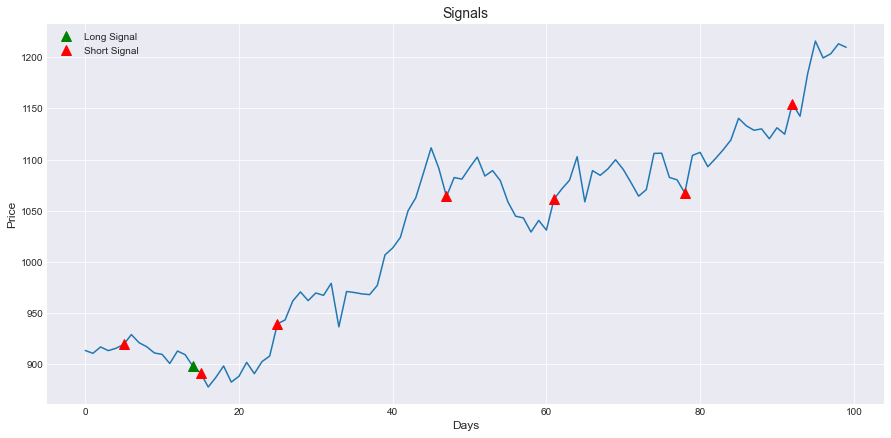

Strategy Backtest
Number of Trades                          43
Start Date               2016-02-05 00:00:00
End Date                 2020-12-30 00:00:00
Duration                           58 months
Avg holding Days  22 days 21:12:33.488372093
Med holding Days            13 days 00:00:00
Min holding Days             1 days 00:00:00
Max holding Days           126 days 00:00:00

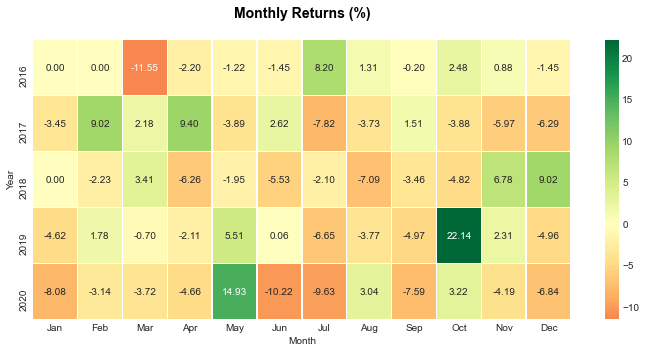

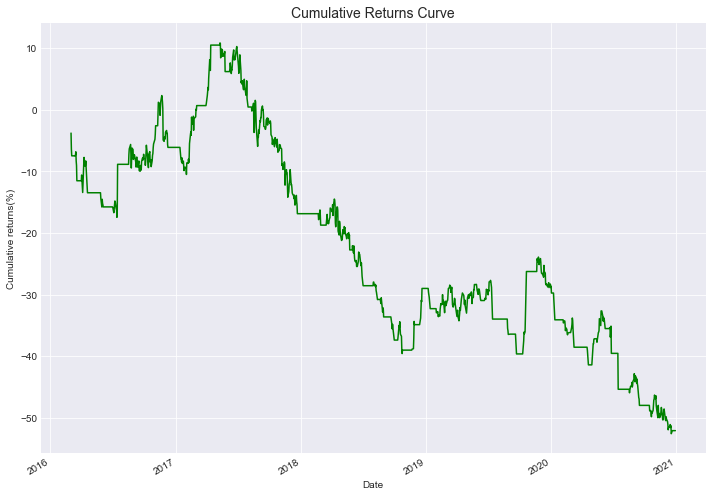

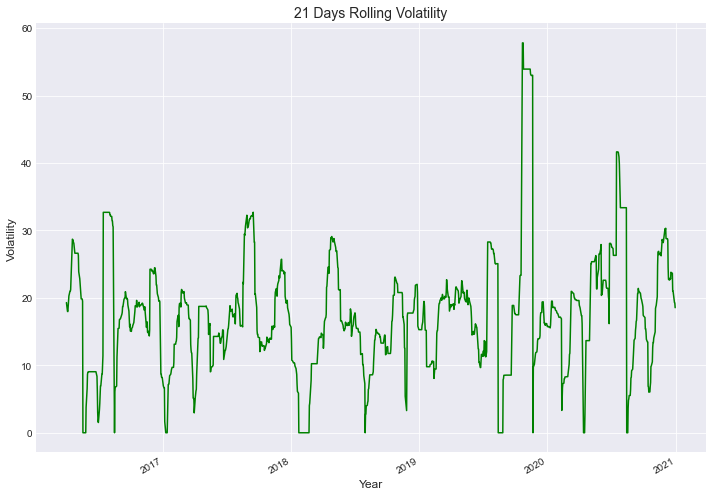

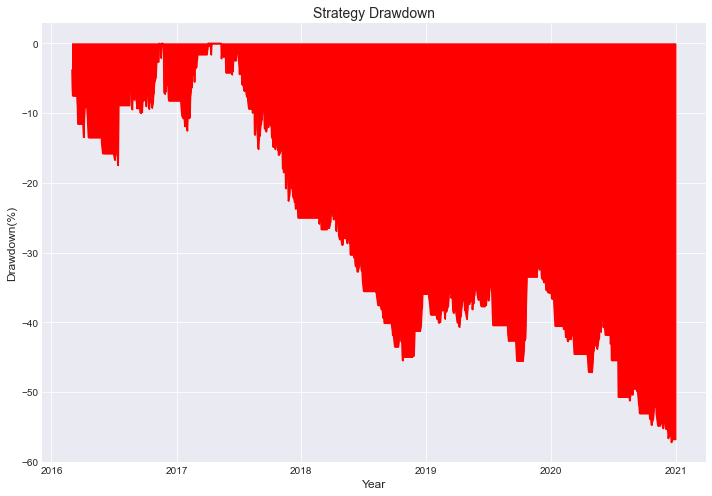

Risk & Returns Metric
Cumulative Return                 -52.07589
Annualised Return                -14.214135
Profit Factor                      0.624852
Win Rate                          23.255814
Annualised Volatility                19.69%
Sharpe ratio                          -0.69
Maximum Drawdown                    -57.20%

In [22]:
# To analyse William %R strategy with Power Spike for INFOSYS
print("\nWilliam %R strategy with Power Spike for INFOSYS")
print("---------------------------------------------------------------------\n")

strategy_analysis(data_infy, "W_signal")


Stochatic Oscillator strategy with Power Spike for INFOSYS
---------------------------------------------------------------------



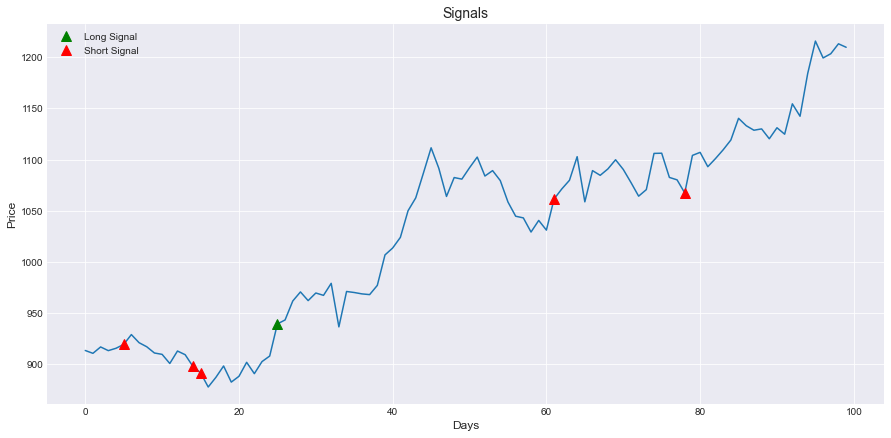

Strategy Backtest
Number of Trades                          31
Start Date               2016-02-05 00:00:00
End Date                 2020-12-30 00:00:00
Duration                           58 months
Avg holding Days  32 days 04:38:42.580645161
Med holding Days            15 days 00:00:00
Min holding Days             2 days 00:00:00
Max holding Days           286 days 00:00:00

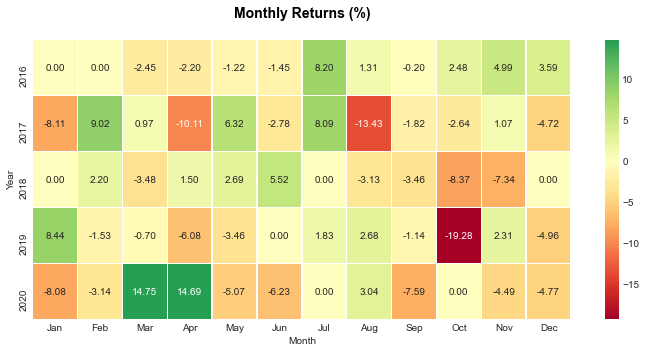

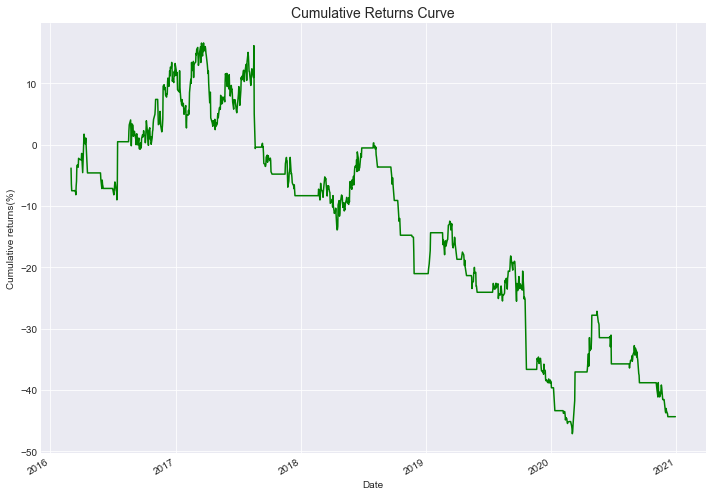

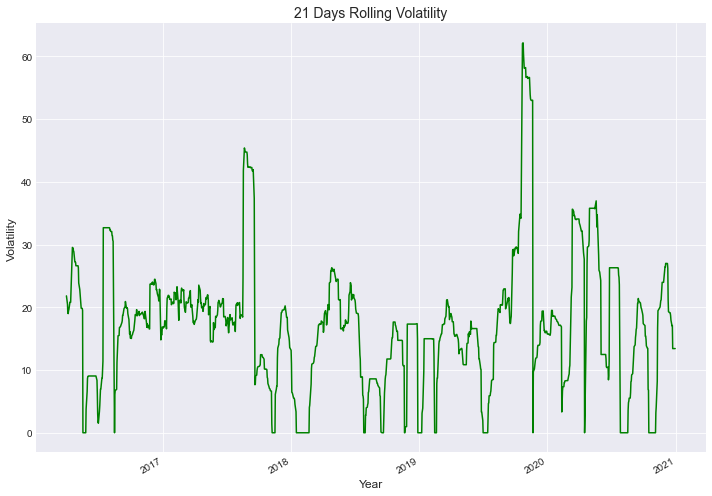

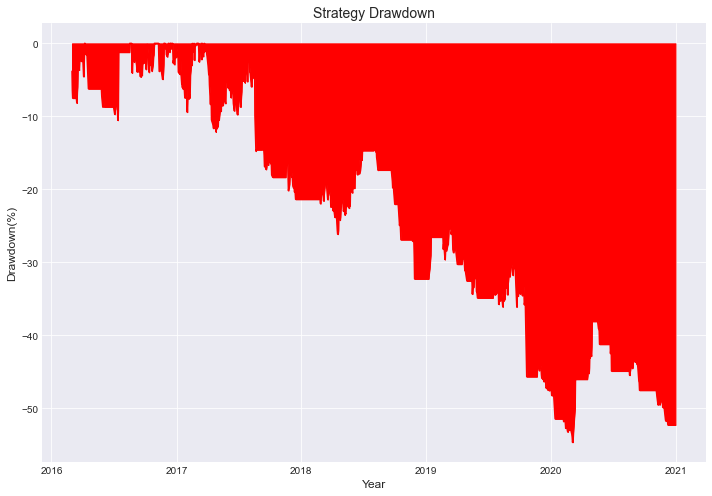

Risk & Returns Metric
Cumulative Return                 -44.34348
Annualised Return                -11.497365
Profit Factor                      0.575614
Win Rate                          22.580645
Annualised Volatility                20.01%
Sharpe ratio                          -0.52
Maximum Drawdown                    -54.64%

In [23]:
# To analyse Stochastic oscillator strategy with Power Spike for INFOSYS
print("\nStochatic Oscillator strategy with Power Spike for INFOSYS")
print("---------------------------------------------------------------------\n")


strategy_analysis(data_infy, "S_signal")


RSI indicator strategy with Power Spike for INFOSYS
---------------------------------------------------------------------



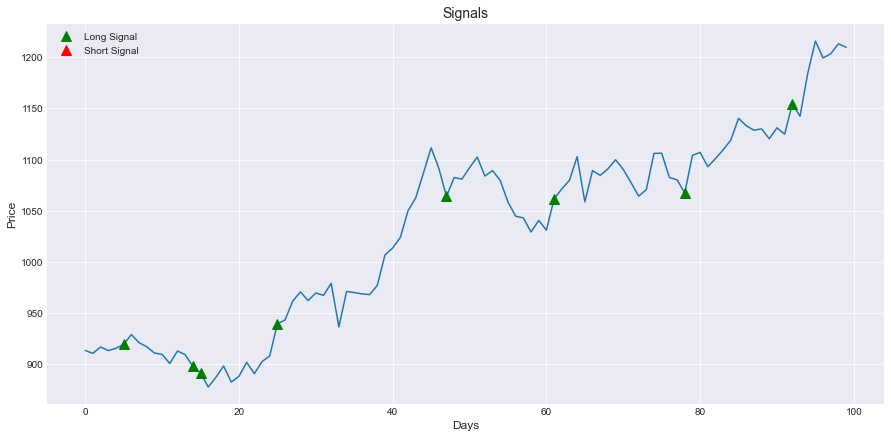

Strategy Backtest
Number of Trades                          33
Start Date               2016-02-05 00:00:00
End Date                 2020-12-30 00:00:00
Duration                           58 months
Avg holding Days  35 days 10:54:32.727272727
Med holding Days            15 days 00:00:00
Min holding Days             1 days 00:00:00
Max holding Days           286 days 00:00:00

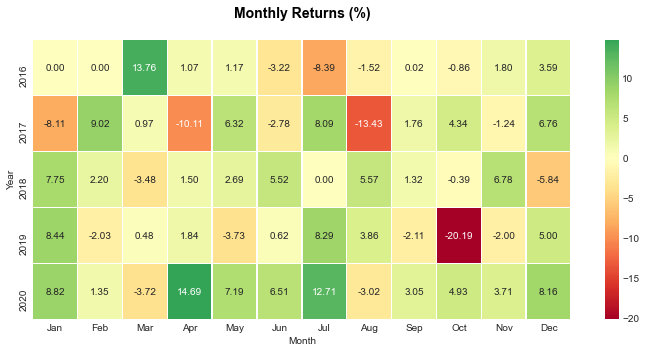

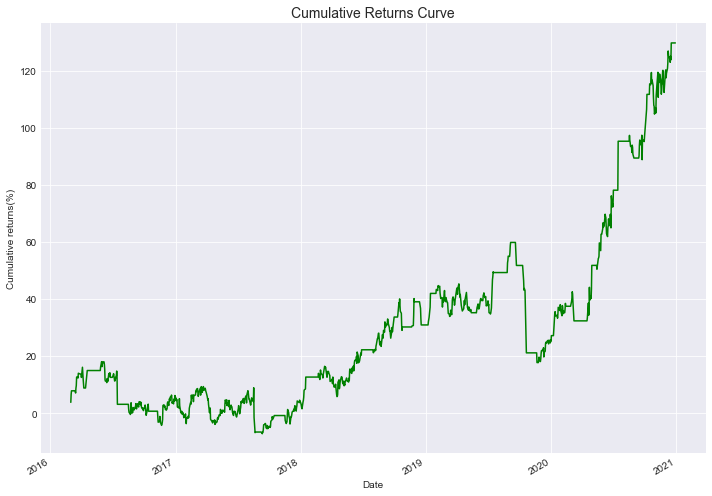

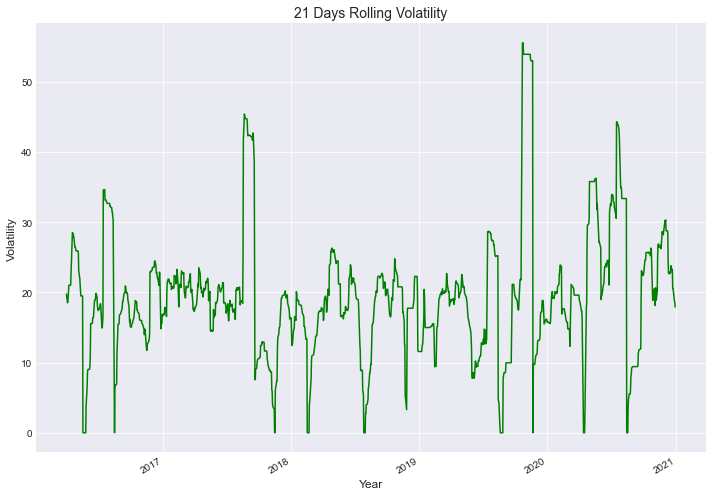

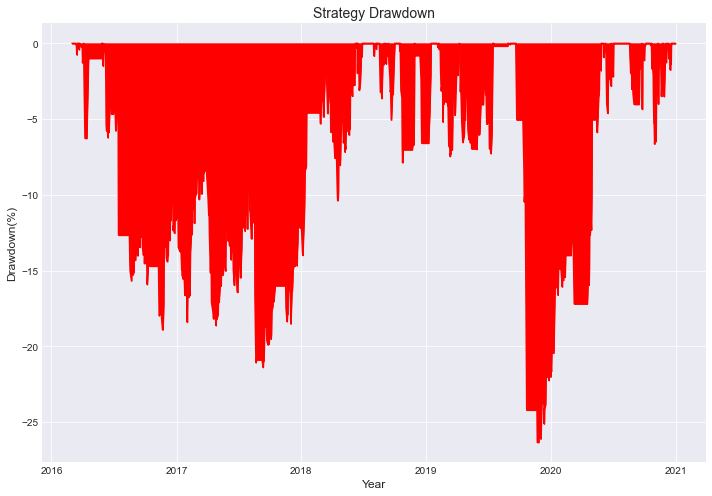

Risk & Returns Metric
Cumulative Return                129.826574
Annualised Return                 18.940315
Profit Factor                      2.051421
Win Rate                          57.575758
Annualised Volatility                21.47%
Sharpe ratio                           0.93
Maximum Drawdown                    -26.35%

In [24]:
# To analyse RSI indicator strategy with Power Spike for INFOSYS
print("\nRSI indicator strategy with Power Spike for INFOSYS")
print("---------------------------------------------------------------------\n")

trd1=strategy_analysis(data_infy, "R_signal")

In [25]:
print("\n-------------------------------------------------------------------")
print("Strategies Analysis for ICICI BANK")
print("-------------------------------------------------------------------\n")


-------------------------------------------------------------------
Strategies Analysis for ICICI BANK
-------------------------------------------------------------------




BolingerBands strategy with Power Spike for ICICI BANK
---------------------------------------------------------------------



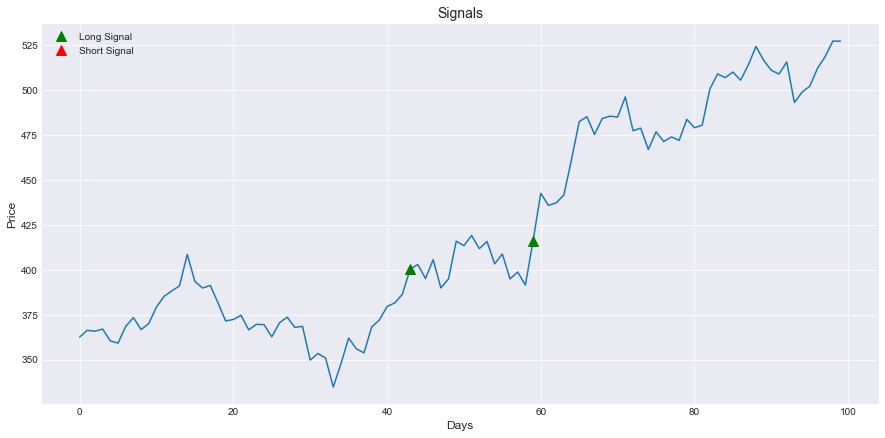

Strategy Backtest
Number of Trades                          31
Start Date               2016-02-05 00:00:00
End Date                 2020-12-30 00:00:00
Duration                           58 months
Avg holding Days  26 days 15:29:01.935483871
Med holding Days            20 days 00:00:00
Min holding Days             1 days 00:00:00
Max holding Days           101 days 00:00:00

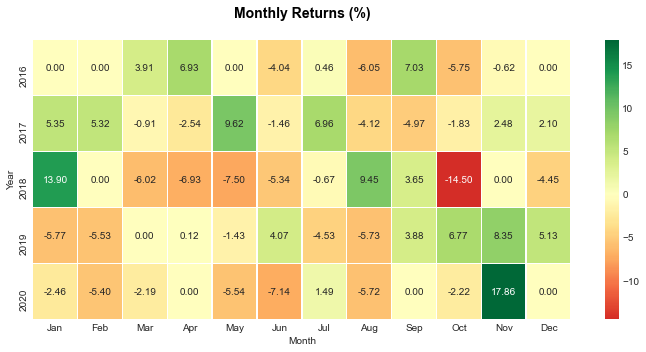

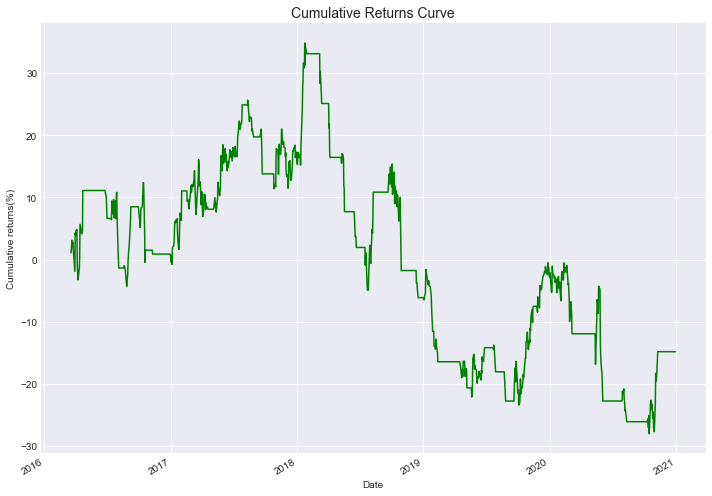

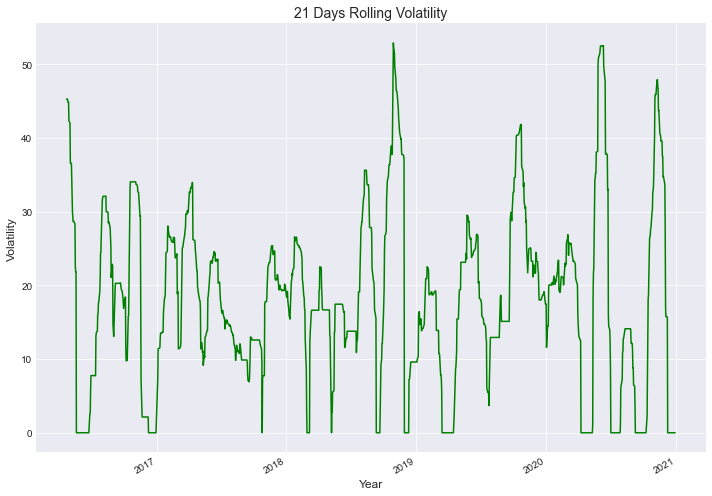

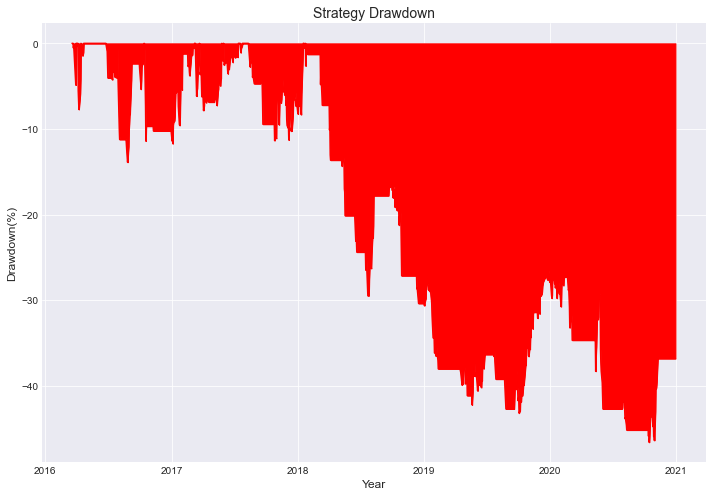

Risk & Returns Metric
Cumulative Return                -14.826058
Annualised Return                 -3.289558
Profit Factor                      0.937246
Win Rate                          29.032258
Annualised Volatility                21.83%
Sharpe ratio                          -0.05
Maximum Drawdown                    -46.62%

In [26]:
# To analyse BolingerBands strategy with Power Spike for ICICI BANK
print("\nBolingerBands strategy with Power Spike for ICICI BANK")
print("---------------------------------------------------------------------\n")

strategy_analysis(data_icicibank, "B_signal")



William %R strategy with Power Spike for ICICI BANK
---------------------------------------------------------------------



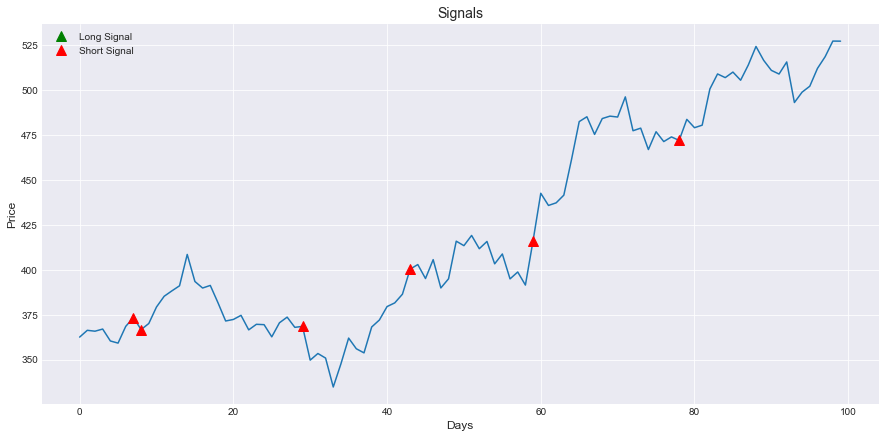

Strategy Backtest
Number of Trades                   45
Start Date        2016-02-05 00:00:00
End Date          2020-12-30 00:00:00
Duration                    58 months
Avg holding Days     17 days 20:48:00
Med holding Days      8 days 00:00:00
Min holding Days      1 days 00:00:00
Max holding Days     83 days 00:00:00

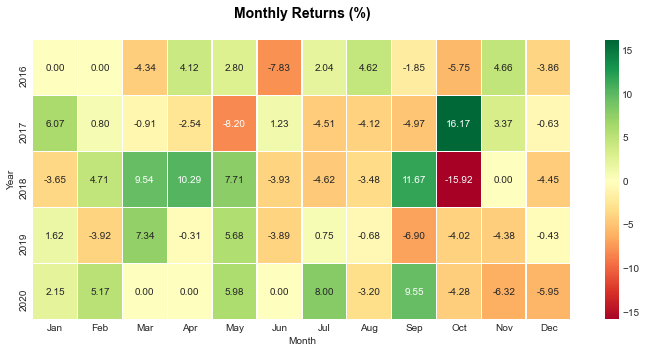

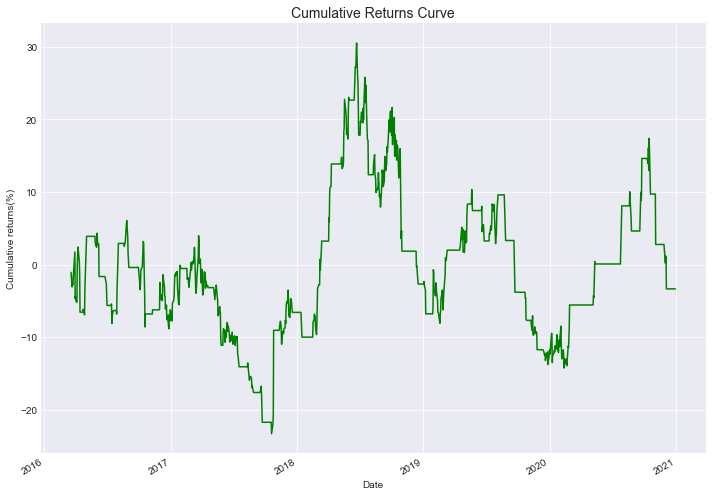

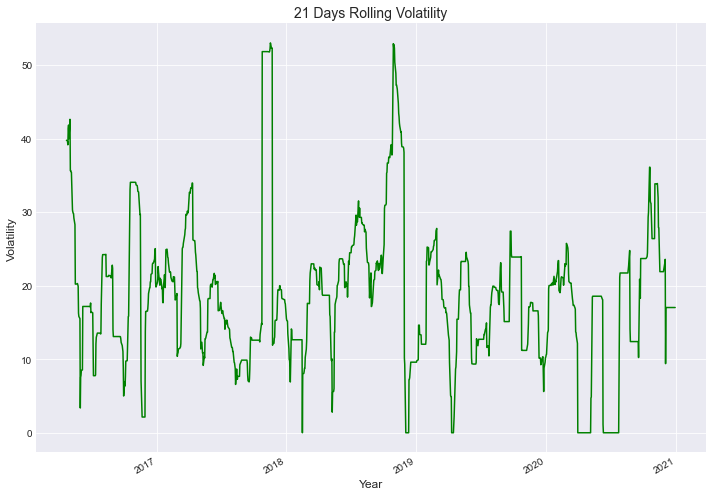

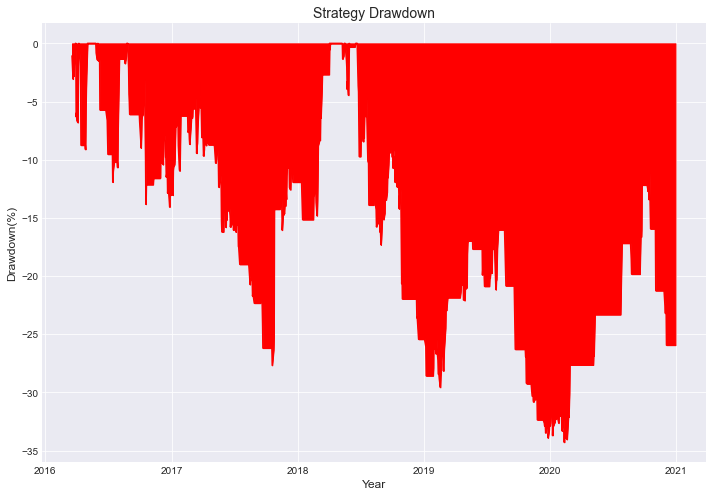

Risk & Returns Metric
Cumulative Return                 -3.347627
Annualised Return                 -0.707203
Profit Factor                       1.10694
Win Rate                          37.777778
Annualised Volatility                21.29%
Sharpe ratio                           0.07
Maximum Drawdown                    -34.30%

In [27]:
# To analyse William %R strategy with Power Spike for ICICI BANK
print("\nWilliam %R strategy with Power Spike for ICICI BANK")
print("---------------------------------------------------------------------\n")

strategy_analysis(data_icicibank, "W_signal")


Stochastic Oscillator strategy with Power Spike for ICICI BANK
---------------------------------------------------------------------



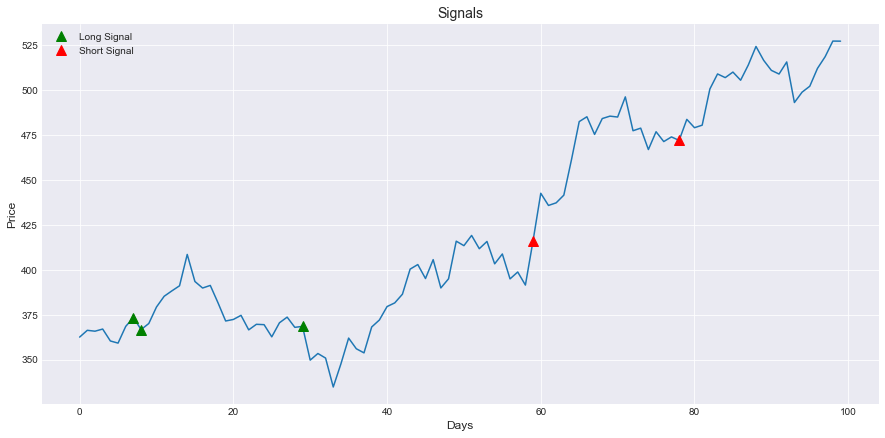

Strategy Backtest
Number of Trades                          41
Start Date               2016-02-05 00:00:00
End Date                 2020-12-30 00:00:00
Duration                           58 months
Avg holding Days  19 days 21:04:23.414634146
Med holding Days            18 days 00:00:00
Min holding Days             1 days 00:00:00
Max holding Days           101 days 00:00:00

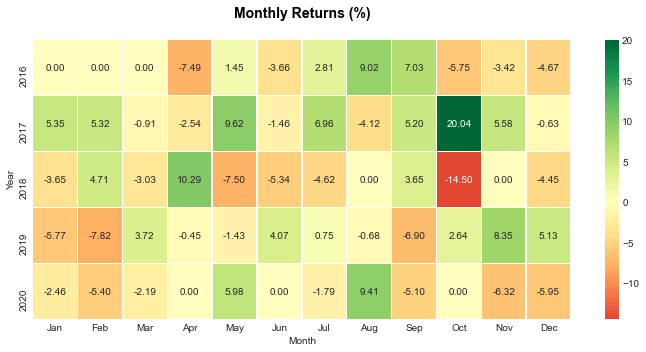

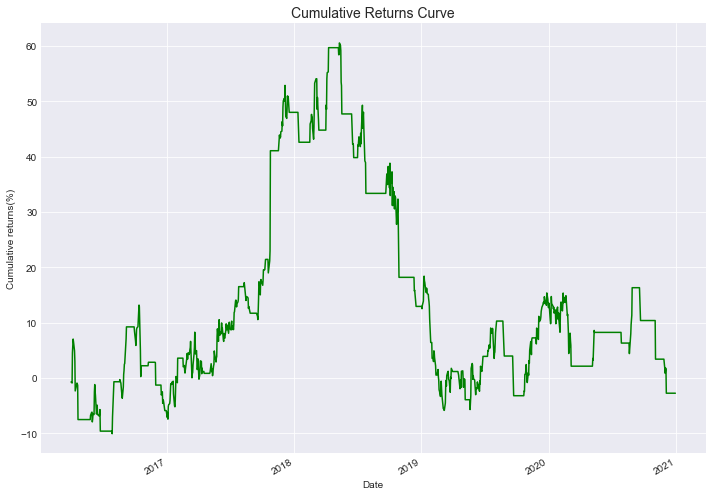

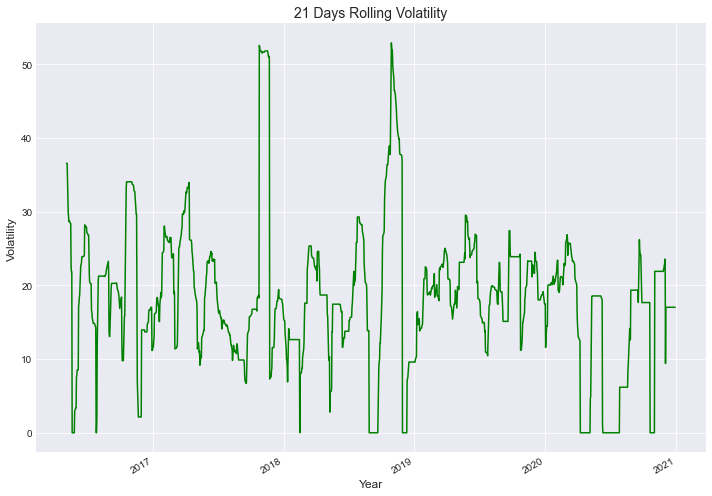

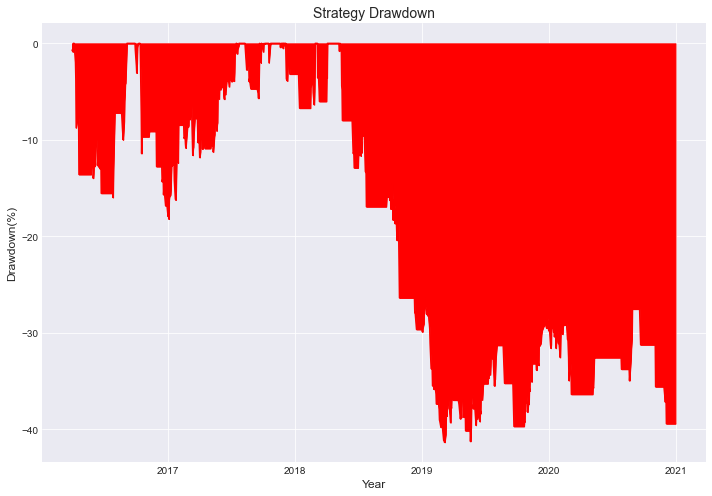

Risk & Returns Metric
Cumulative Return                 -2.727564
Annualised Return                 -0.574764
Profit Factor                      1.059306
Win Rate                           39.02439
Annualised Volatility                20.99%
Sharpe ratio                           0.08
Maximum Drawdown                    -41.36%

In [28]:
# To analyse Stochastic oscillator strategy with Power Spike for ICICI BANK
print("\nStochastic Oscillator strategy with Power Spike for ICICI BANK")
print("---------------------------------------------------------------------\n")

strategy_analysis(data_icicibank, "S_signal")


RSI indicator strategy with Power Spike for ICICI BANK
---------------------------------------------------------------------



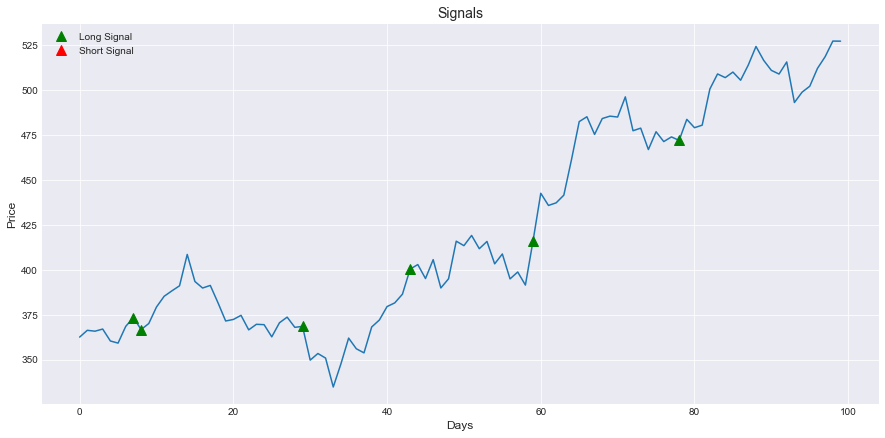

Strategy Backtest
Number of Trades                          33
Start Date               2016-02-05 00:00:00
End Date                 2020-12-30 00:00:00
Duration                           58 months
Avg holding Days  30 days 05:49:05.454545454
Med holding Days            22 days 00:00:00
Min holding Days             1 days 00:00:00
Max holding Days           166 days 00:00:00

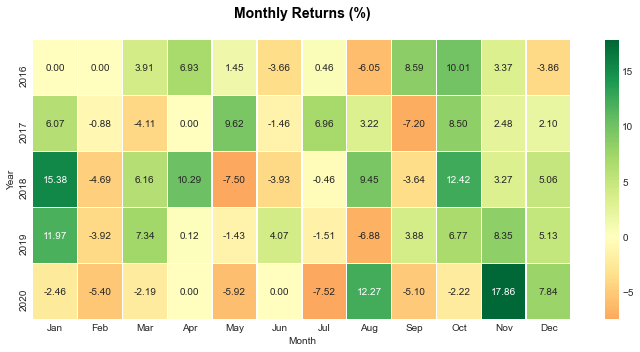

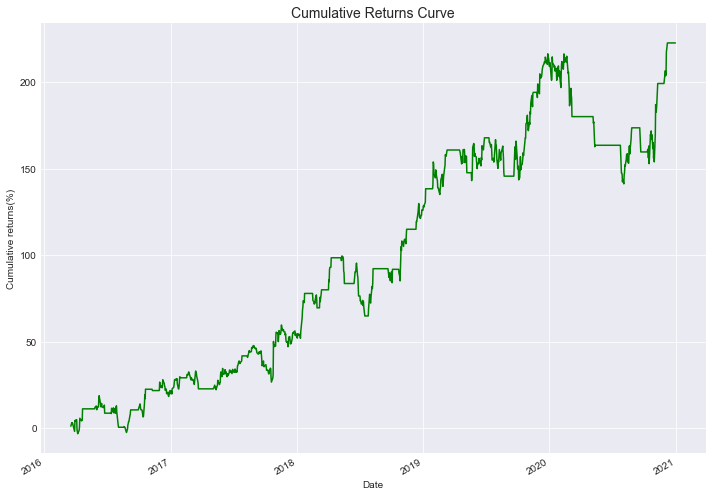

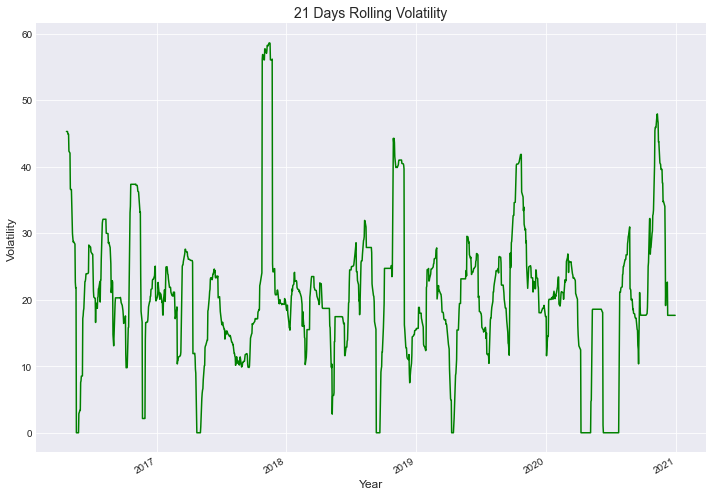

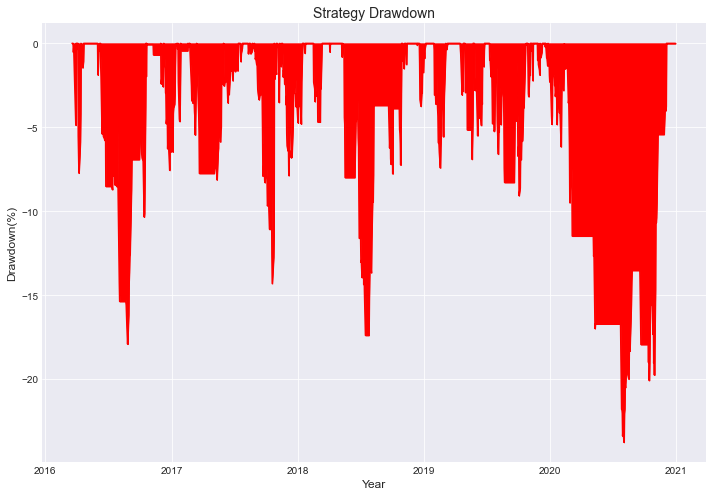

Risk & Returns Metric
Cumulative Return                222.673802
Annualised Return                 27.657119
Profit Factor                      2.547701
Win Rate                          51.515152
Annualised Volatility                23.29%
Sharpe ratio                           1.19
Maximum Drawdown                    -23.76%

In [29]:
# To analyse RSI indicator strategy with Power Spike for ICICI BANK
print("\nRSI indicator strategy with Power Spike for ICICI BANK")
print("---------------------------------------------------------------------\n")

trd1=strategy_analysis(data_icicibank, "R_signal")

## Competitor strategy

In [3]:
#function to get data from yahoo finance
def get_yf_data(symbol, start_date, end_date):
    data = yf.download(symbol, start=start_date,end=end_date,auto_adjust = True)
    return data

# calculating SMA for bollinger bands
def sma(data, window):
    sma = data["Volume"].rolling(window = window).mean()#calculating SMA over specified window i.e. 20 days
    return sma

# calculating bollinger bands
def bb(data, window):
    std = data["Volume"].rolling(window = window).std()
    upper_bb = data["sma"] + std * 2
    return upper_bb

# calculating volume penetration i.e. percentage of volume above upper bollinger band
def vol_pen(data):
    vol_pen = ((data["Volume"]-data["upper_bb"])/data["Volume"])*100
    return vol_pen

# determining volume spike i.e. volume > upper bollinger band
def vol_spike(data):
    data["vol_spike"] = np.where(data["vol_pen"]>0,True,False)
    return data

#define Gap-up i.e. trade day where a volume spike occurs and low > previous high
def gap_up(data):
    data["Prev High"] = data["High"].shift(1)
    data["Gap_Up"] = np.where(data["vol_spike"]==True,(np.where(data["Low"]>data["Prev High"],True,False)),False)
    return data

#define Gap-down i.e. trade day where a volume spike occurs and high < prev low
def gap_down(data):
    data["Prev Low"] = data["Low"].shift(1)
    data["Gap_Down"] = np.where(data["vol_spike"]==True,(np.where(data["High"]<data["Prev Low"],True,False)),False)
    return data

# Additional Data Massaging
def add_data_mass(data):
    data["Prev Open"] = data["Open"].shift(1)
    data["Prev Close"] = data["Close"].shift(1)
    data["Lows"] = data["Close"] - data["Prev Close"]
    data["Highs"] = data["Open"] - data["Prev Open"]
    data = data.dropna()
    return data


#defining Entry and exit points
def signal(temp):
    temp["Long_Signal"] = ""
    temp["Short_Signal"] = ""
    long_trade_signal=False
    short_trade_signal=False
    #trade_type=""
    i=0
    #for long trade entry we are looking for gap up with blue candle on the day
    while i<(temp.shape[0]-2):
        if (temp["Gap_Up"][i]) and long_trade_signal==False and (temp["Close"][i]>temp["Open"][i]):
            temp["Long_Signal"][i]="Long Entry"
            long_trade_signal = True
        #for long trade exit we are looking for two consecutive days with lower lows
        if long_trade_signal:
            if (temp["Lows"][i+1]<0 and temp["Lows"][i+2]<0):
                temp["Long_Signal"][i+2]="Long Exit"
                long_trade_signal=False
                i=i+3
            else:
                i=i+1
        else:
            i=i+1
    i=0
    #for short trade entry we are looking for gap down with red candle on the day
    while i<(temp.shape[0]-2):
        if (temp["Gap_Down"][i]) and short_trade_signal==False and (temp["Close"][i]<temp["Open"][i]):
            temp["Short_Signal"][i]="Short Entry"
            short_trade_signal = True
        #for short trade exit we are looking for two consecutive days with higher highs
        if short_trade_signal:
            if (temp["Highs"][i+1]>0 and temp["Highs"][i+2]>0):
                temp["Short_Signal"][i+2]="Short Exit"
                short_trade_signal=False
                i=i+3
            else:
                i=i+1
        else:
            i=i+1
    return temp

In [4]:
# creating trade book With columns: Positions(Long/Short), Entry Time,  Entry Price, Exit Time, Exit Price and P&L. 
def create_trade_book(data):
    data1 = pd.DataFrame(columns=["Position","Entry Time","Entry Price", "Exit Time", "Exit Price","P&L"])
    for i in range(0,data.shape[0]):
        if data["Long_Signal"][i]=="Long Entry":
            position = "Long"
            entry_price = data["Close"][i]
            entry_time = data.index[i]
        if data["Long_Signal"][i]=="Long Exit":
            exit_price = data["Close"][i]
            exit_time = data.index[i]
            df2 = {'Position': position, 'Entry Time': entry_time, 'Entry Price': entry_price,'Exit Time': exit_time, 'Exit Price':exit_price,'P&L':0}
            data1 = data1.append(df2,ignore_index=True)
    for i in range(0,data.shape[0]):
        if data["Short_Signal"][i]=="Short Entry":
            position = "Short"
            entry_price = data["Close"][i]
            entry_time = data.index[i]
        if data["Short_Signal"][i]=="Short Exit":
            exit_price = data["Close"][i]
            exit_time = data.index[i]
            df2 = {'Position': position, 'Entry Time': entry_time, 'Entry Price': entry_price,'Exit Time': exit_time, 'Exit Price':exit_price,'P&L':0}
            data1 = data1.append(df2,ignore_index=True) 
    for i in range(0,data1.shape[0]):
        if data1["Position"][i] == "Long":
            data1["P&L"][i] = round(np.log(data1["Exit Price"][i] / data1["Entry Price"][i]),4)*100
        if data1["Position"][i] == "Short":
            data1["P&L"][i] = round(np.log(data1["Entry Price"][i]/data1["Exit Price"][i]),4)*100  
    return data1

In [5]:
#function defined to run all the functions in one go
def perform_all(symbol,start_date,end_date):
    data = get_yf_data(symbol,start_date,end_date)
    data["sma"] = sma(data, 20)
    data['upper_bb'] = bb(data, 20)
    data['vol_pen'] = vol_pen(data)
    data = vol_spike(data)
    data = gap_up(data)
    data = gap_down(data)
    data = add_data_mass(data)
    data = signal(data)
    trade_book = create_trade_book(data)
    backtest(data,trade_book)
    risk_return(data, trade_book)   


 Competitor Strategy for Reliance Industries Ltd
---------------------------------------------------------------------

[*********************100%***********************]  1 of 1 completed


Strategy Backtest
Number of Trades                   16
Start Date        2016-01-29 00:00:00
End Date          2020-12-30 00:00:00
Duration                    59 months
Avg holding Days      9 days 16:30:00
Med holding Days      9 days 00:00:00
Min holding Days      3 days 00:00:00
Max holding Days     19 days 00:00:00

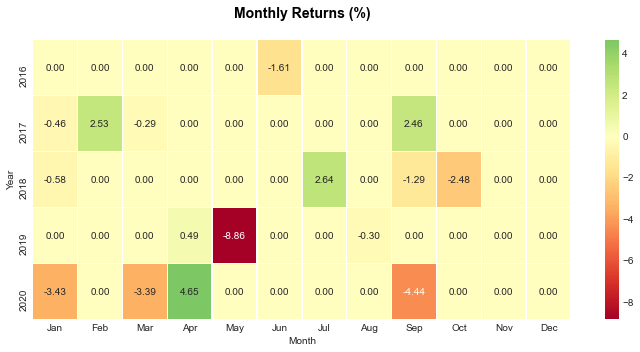

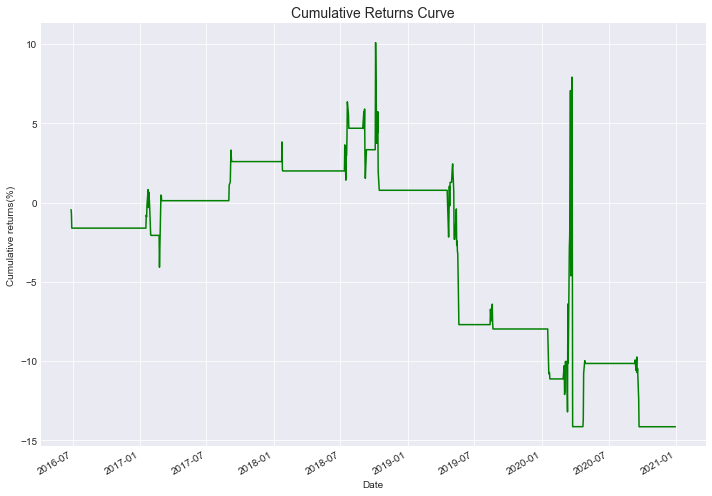

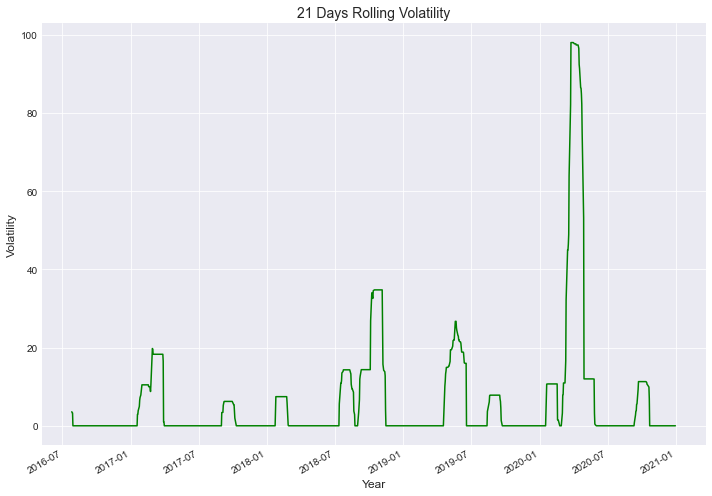

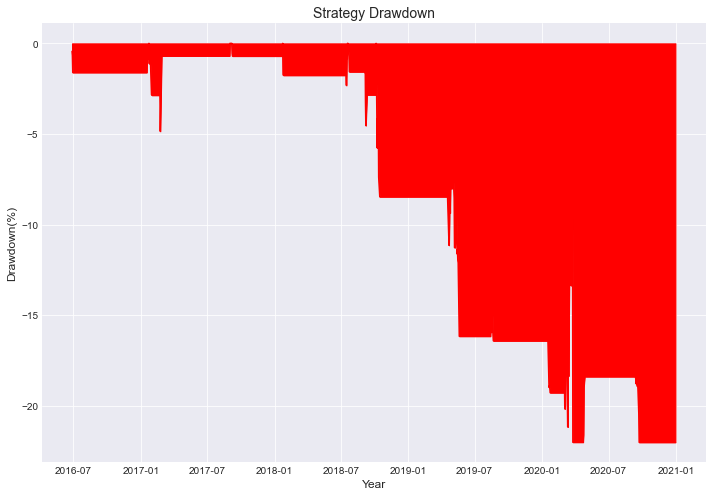

Risk & Returns Metric
Cumulative Return                -14.143387
Annualised Return                 -3.115819
Profit Factor                      0.725215
Win Rate                               37.5
Annualised Volatility                15.30%
Sharpe ratio                          -0.15
Maximum Drawdown                    -22.02%

In [16]:
# Competitor Strategy for Reliance Industries Ltd
print("\n Competitor Strategy for Reliance Industries Ltd")
print("---------------------------------------------------------------------\n")

perform_all("RELIANCE.NS","2016-01-01","2020-12-31")



 Competitor Strategy for HDFC BANK
---------------------------------------------------------------------

[*********************100%***********************]  1 of 1 completed


Strategy Backtest
Number of Trades                    7
Start Date        2016-01-29 00:00:00
End Date          2020-12-30 00:00:00
Duration                    59 months
Avg holding Days     12 days 00:00:00
Med holding Days     12 days 00:00:00
Min holding Days      4 days 00:00:00
Max holding Days     17 days 00:00:00

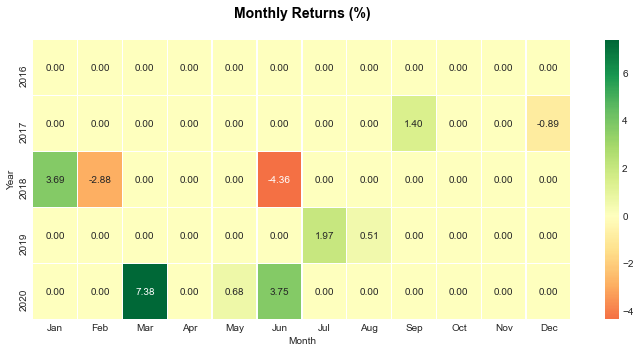

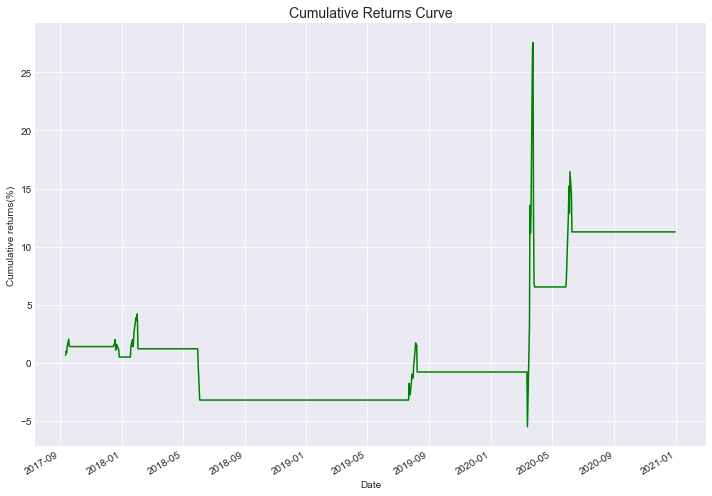

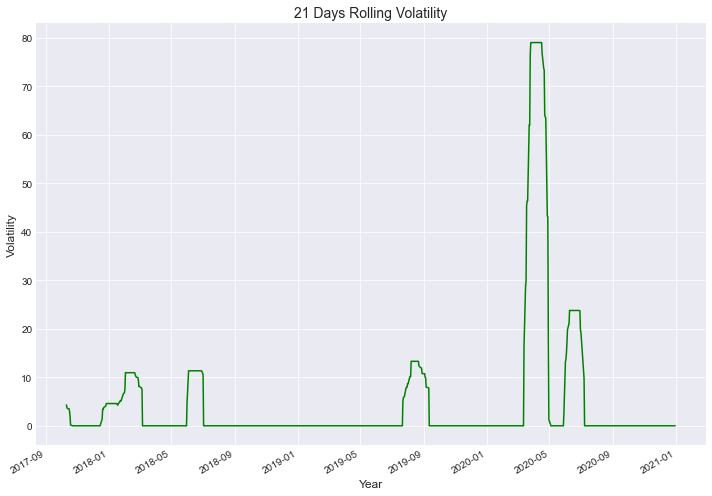

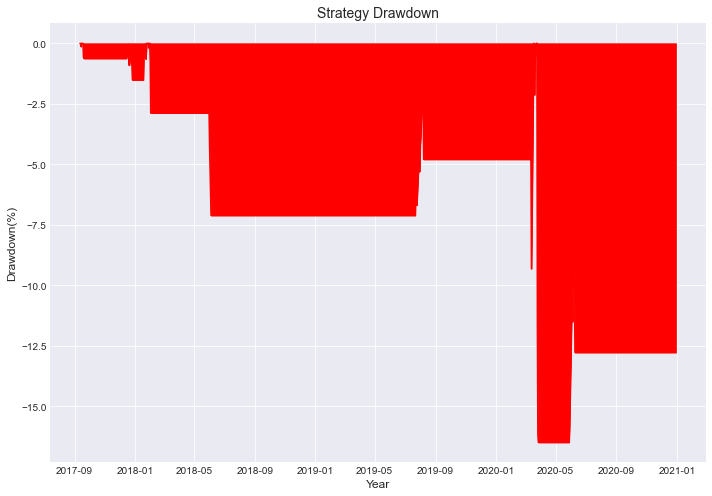

Risk & Returns Metric
Cumulative Return                 11.269006
Annualised Return                   2.24128
Profit Factor                       3.95709
Win Rate                          71.428571
Annualised Volatility                13.45%
Sharpe ratio                           0.31
Maximum Drawdown                    -16.49%

In [17]:
# Competitor Strategy for HDFC BANK
print("\n Competitor Strategy for HDFC BANK")
print("---------------------------------------------------------------------\n")

perform_all("HDFCBANK.NS","2016-01-01","2020-12-31")



 Competitor Strategy for INFOSYS
---------------------------------------------------------------------

[*********************100%***********************]  1 of 1 completed


Strategy Backtest
Number of Trades                          11
Start Date               2016-01-29 00:00:00
End Date                 2020-12-30 00:00:00
Duration                           59 months
Avg holding Days  11 days 06:32:43.636363636
Med holding Days             7 days 00:00:00
Min holding Days             3 days 00:00:00
Max holding Days            27 days 00:00:00

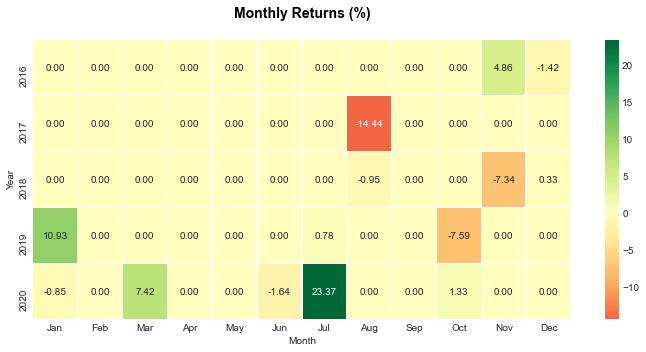

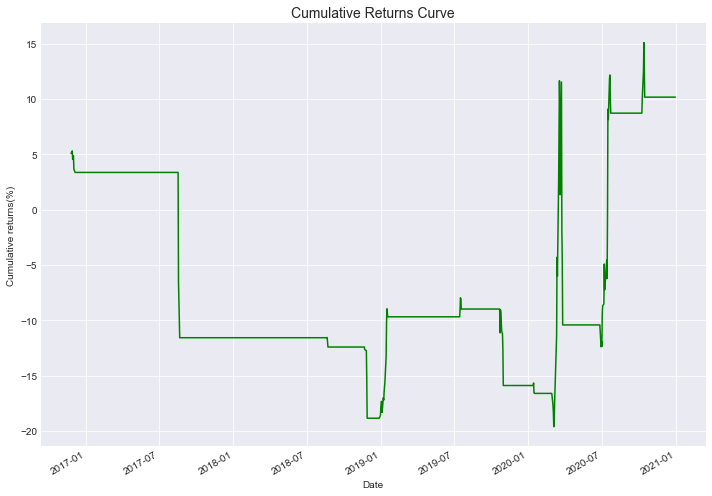

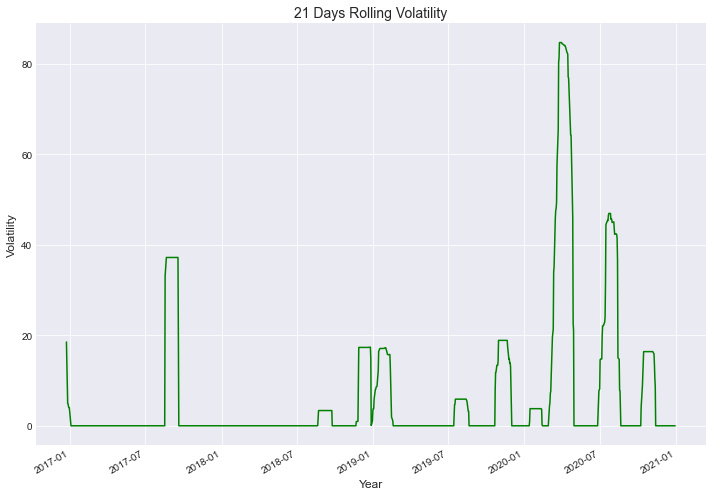

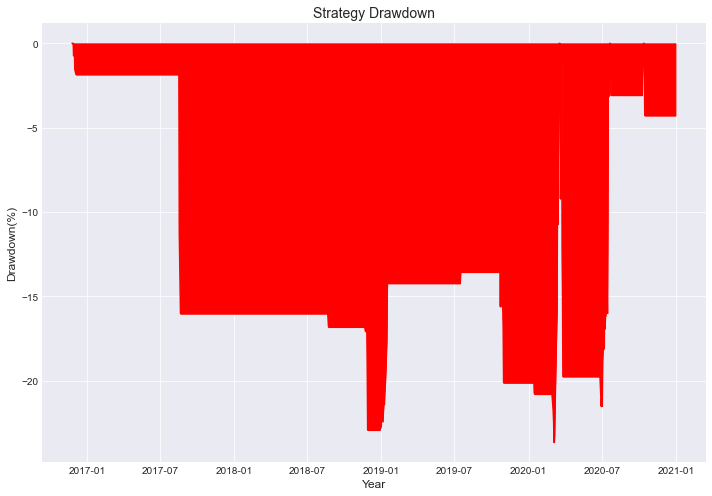

Risk & Returns Metric
Cumulative Return                  10.17086
Annualised Return                  2.030999
Profit Factor                      1.495671
Win Rate                          54.545455
Annualised Volatility                16.01%
Sharpe ratio                           0.23
Maximum Drawdown                    -23.66%

In [18]:
# Competitor Strategy for INFOSYS
print("\n Competitor Strategy for INFOSYS")
print("---------------------------------------------------------------------\n")

perform_all("INFY.NS","2016-01-01","2020-12-31")



 Competitor Strategy for ICICI BANK
---------------------------------------------------------------------

[*********************100%***********************]  1 of 1 completed


Strategy Backtest
Number of Trades                   25
Start Date        2016-01-29 00:00:00
End Date          2020-12-30 00:00:00
Duration                    59 months
Avg holding Days      9 days 10:33:36
Med holding Days      6 days 00:00:00
Min holding Days      2 days 00:00:00
Max holding Days     44 days 00:00:00

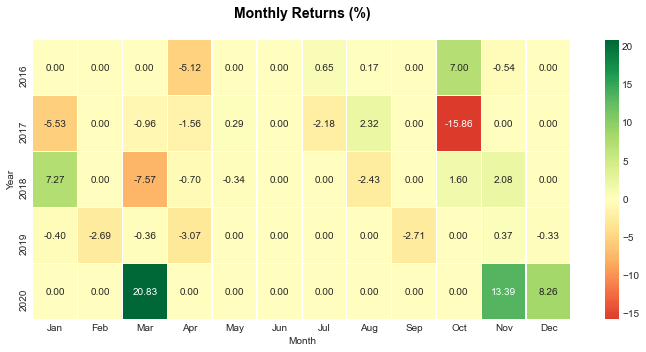

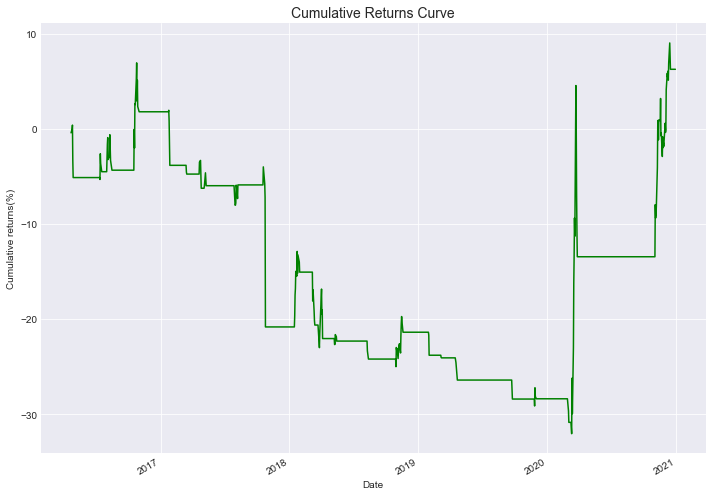

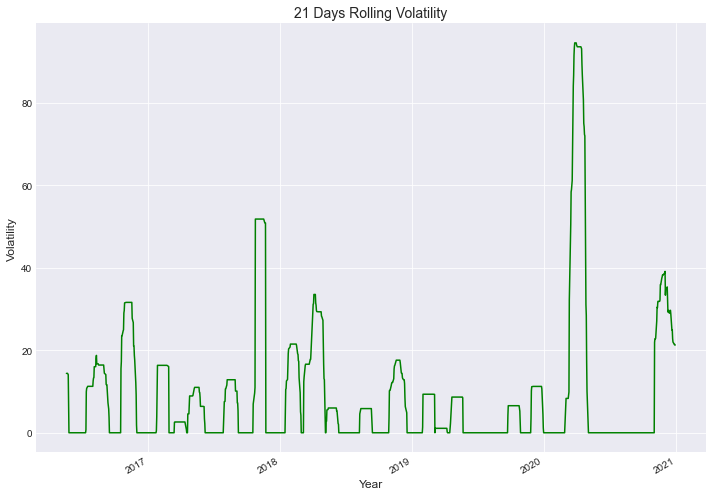

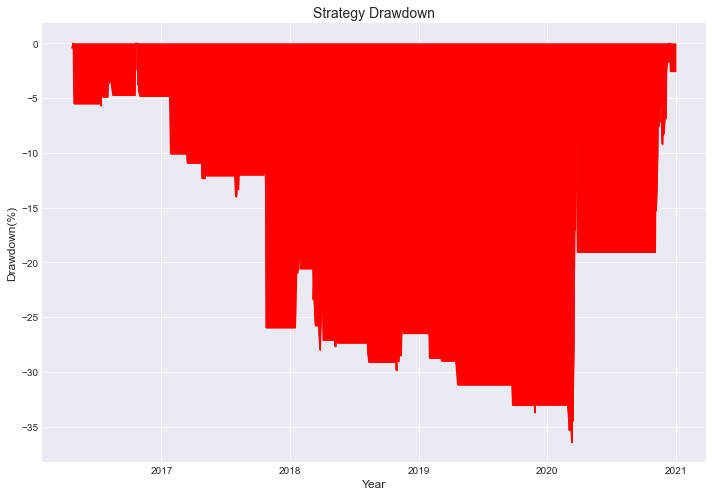

Risk & Returns Metric
Cumulative Return                  6.260995
Annualised Return                  1.268562
Profit Factor                      1.290353
Win Rate                               40.0
Annualised Volatility                18.00%
Sharpe ratio                           0.16
Maximum Drawdown                    -36.44%

In [19]:
# Competitor Strategy for ICICI BANK
print("\n Competitor Strategy for ICICI BANK")
print("---------------------------------------------------------------------\n")

perform_all("ICICIBANK.NS","2016-01-01","2020-12-31")
